In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline
%autoreload 1
import pickle
import numpy as np
from functools import partial
import MDAnalysis

from pathlib import Path

import matplotlib.pyplot as plt
import numpy.typing as npt

import pandas as pd

from scipy import integrate, interpolate, stats, signal
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

%aimport util
from plot_helper import *

Matplotlib Version: 3.6.3


In [3]:
from MDAnalysis.analysis.leaflet import LeafletFinder

def largest_groups(atoms):
    """
    From a list of sizes, find out the indices of the two largest groups. These should correspond to the two leaflets of the bilayer.

    Keyword arguments:
    atoms -- list of sizes of clusters identified by LeafletFinder
    """
    largest = 0
    second_largest = 0

    for i in atoms:
        if atoms[i] > largest:
            largest_index = i
            largest = atoms[i]

    for i in atoms:
        if atoms[i] > second_largest and i != largest_index:
            second_largest_index = i
            second_largest = atoms[i]

    return (largest_index, second_largest_index)


def determine_leaflets(universe, selection="all"):
    """
    From a selection of phosphates, determine which belong to the upper and lower leaflets.

    Keyword arguments:
    universe -- an MDAnalysis Universe object
    phosphateSelection -- a string specifying how to select the phosphate atoms (e.g. "name P1")
    """
    leaflets = {}

    # calculate the z value of the phosphates defining the bilayer (assumes bilayer is in x and y..)
    ag = universe.atoms.select_atoms(selection)
    bilayerCentre = ag.center_of_geometry()[2]

    # apply the MDAnalysis LeafletFinder graph-based method to determine the two largest groups which
    #  should correspond to the upper and lower leaflets
    phosphates = LeafletFinder(universe, selection)

    # find the two largest groups - required as the first two returned by LeafletFinder, whilst usually are the largest, this is not always so
    (a, b) = largest_groups(phosphates.sizes())

    # check to see where the first leaflet lies
    if phosphates.group(a).centroid()[2] > bilayerCentre:
        leaflets["upper"] = phosphates.group(a)
        leaflets["lower"] = phosphates.group(b)
    else:
        leaflets["lower"] = phosphates.group(a)
        leaflets["upper"] = phosphates.group(b)

    return leaflets



In [4]:

lipids = ["POPC", "DOPC", "POPE", "DOPE", "CDL1", "CDL2", "POPG", "DOPG"]
leaflets = ["upper", "lower"]

queries = {
    "PC": "resname POPC or resname DOPC",
    "PE": "resname POPE or resname DOPE",
    "CDL": "resname CDL1 or resname CDL2",
    "PG": "resname POPG or resname DOPG",
}

po4_neighbor_sel = "name PO4 or name GL0"

def get_midpoints(x):
    return ((x + np.roll(x, -1))/2)[:-1]

def mean_curvature(Z):
    """
    Calculates mean curvature from Z cloud points.


    Parameters
    ----------
    Z: np.ndarray.
        Multidimensional array of shape (n,n).


    Returns
    -------
    H : np.ndarray.
        The result of gaussian curvature of Z. Returns multidimensional
        array object with values of gaussian curvature of shape `(n, n)`.

    """

    Zy, Zx = np.gradient(Z)
    Zxy, Zxx = np.gradient(Zx)
    Zyy, _ = np.gradient(Zy)

    H = (1 + Zx**2) * Zyy + (1 + Zy**2) * Zxx - 2 * Zx * Zy * Zxy
    H = H / (2 * (1 + Zx**2 + Zy**2)**(1.5))

    return H


MDAnalysis  : INFO     MDAnalysis 2.2.0 STARTED logging to 'MDAnalysis.log'
MDAnalysis  : INFO     MDAnalysis 2.2.0 STARTED logging to 'MDAnalysis.log'
MDAnalysis  : INFO     MDAnalysis 2.2.0 STARTED logging to 'MDAnalysis.log'


1


/home/ctlee/.conda/envs/mda/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


  0%|          | 0/10000 [00:00<?, ?it/s]

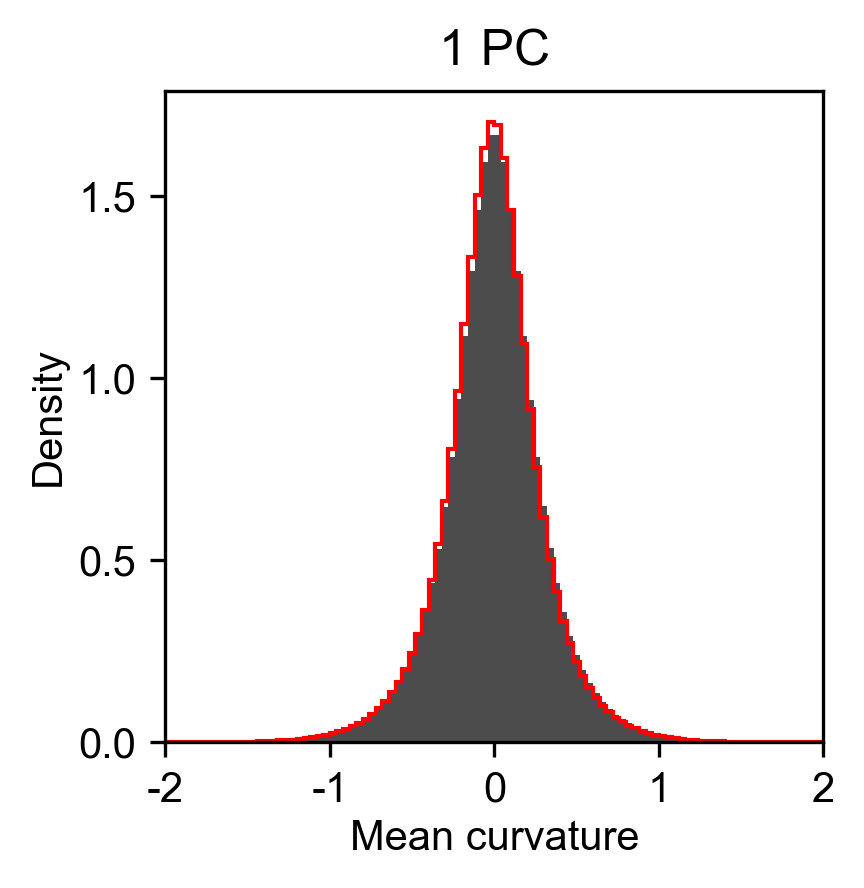

  0%|          | 0/10000 [00:00<?, ?it/s]

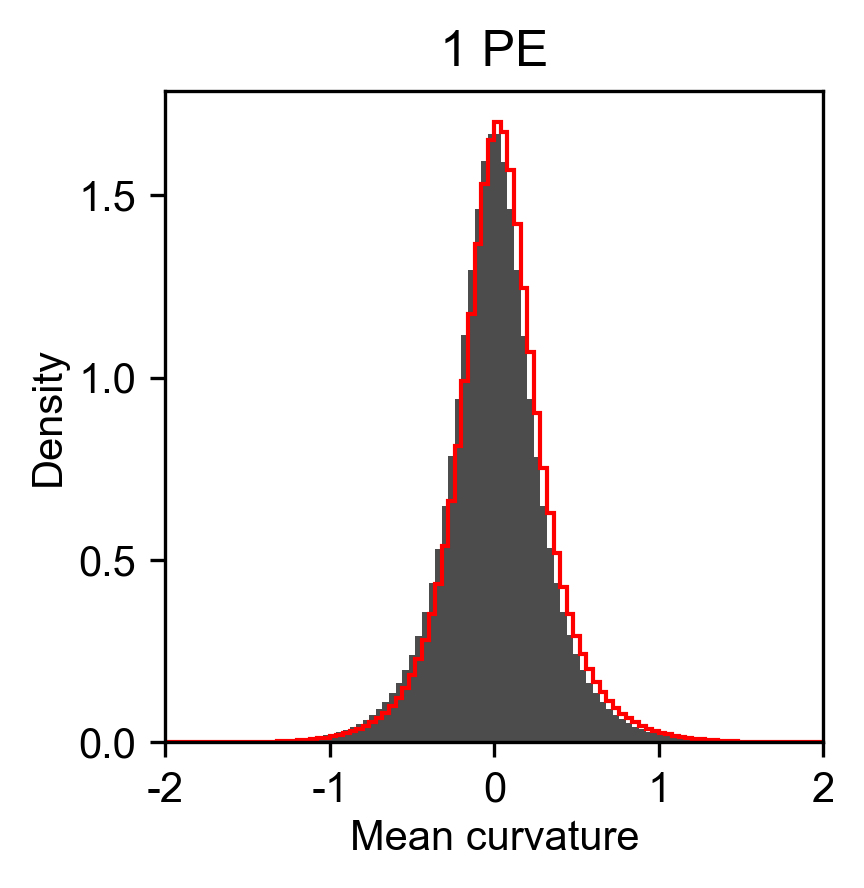

  0%|          | 0/10000 [00:00<?, ?it/s]

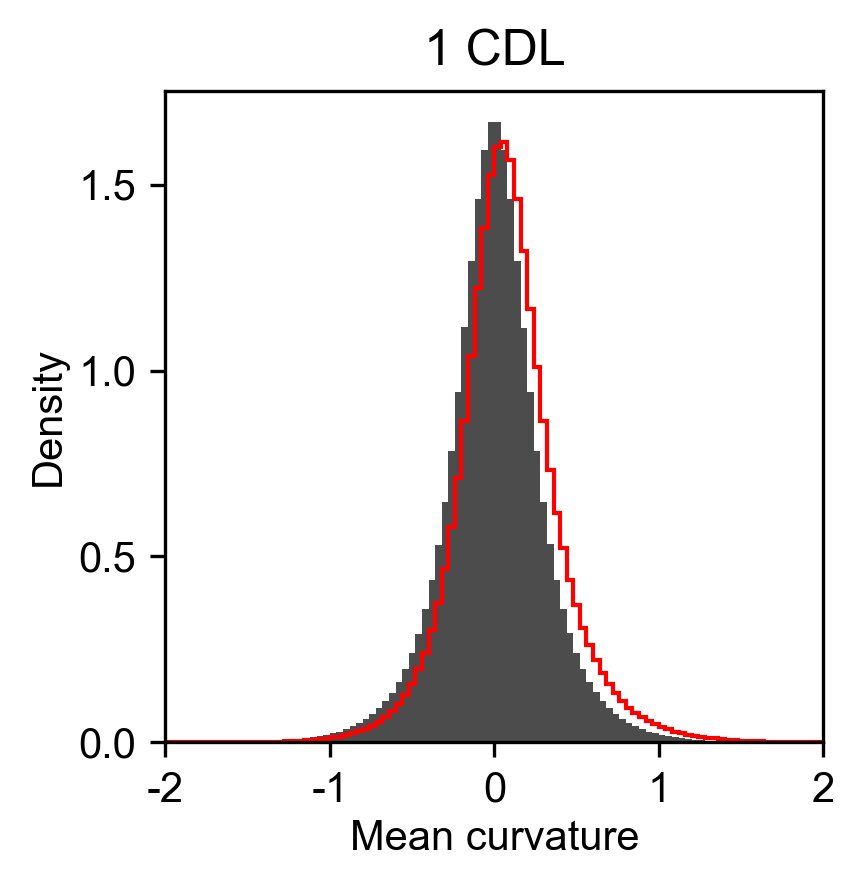

2


  0%|          | 0/10000 [00:00<?, ?it/s]

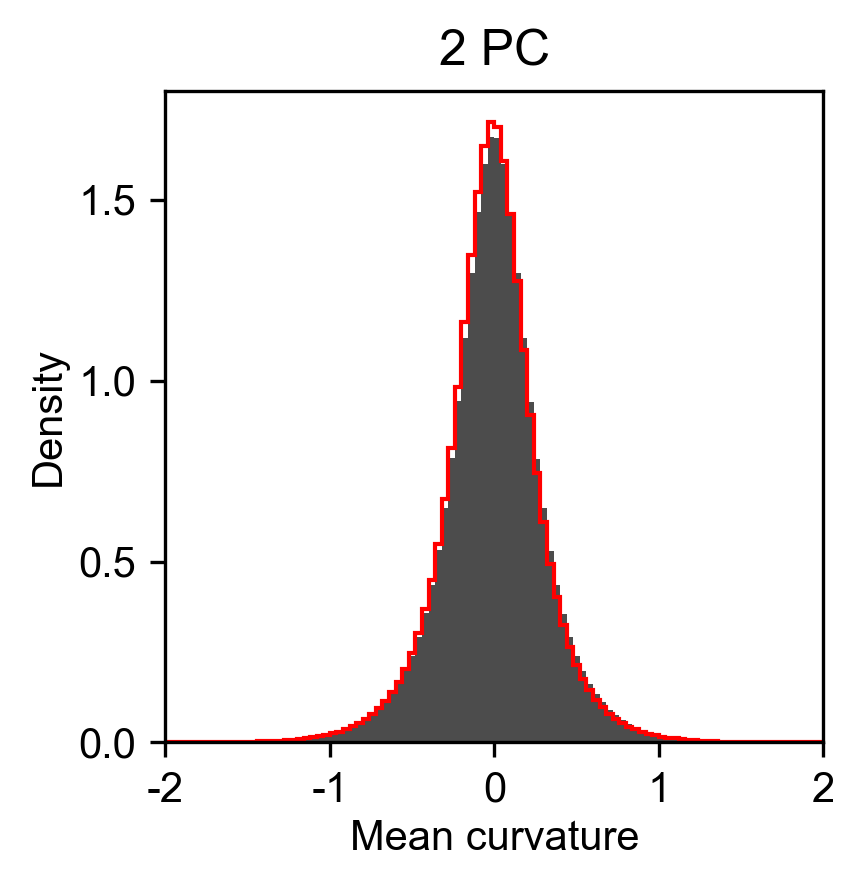

  0%|          | 0/10000 [00:00<?, ?it/s]

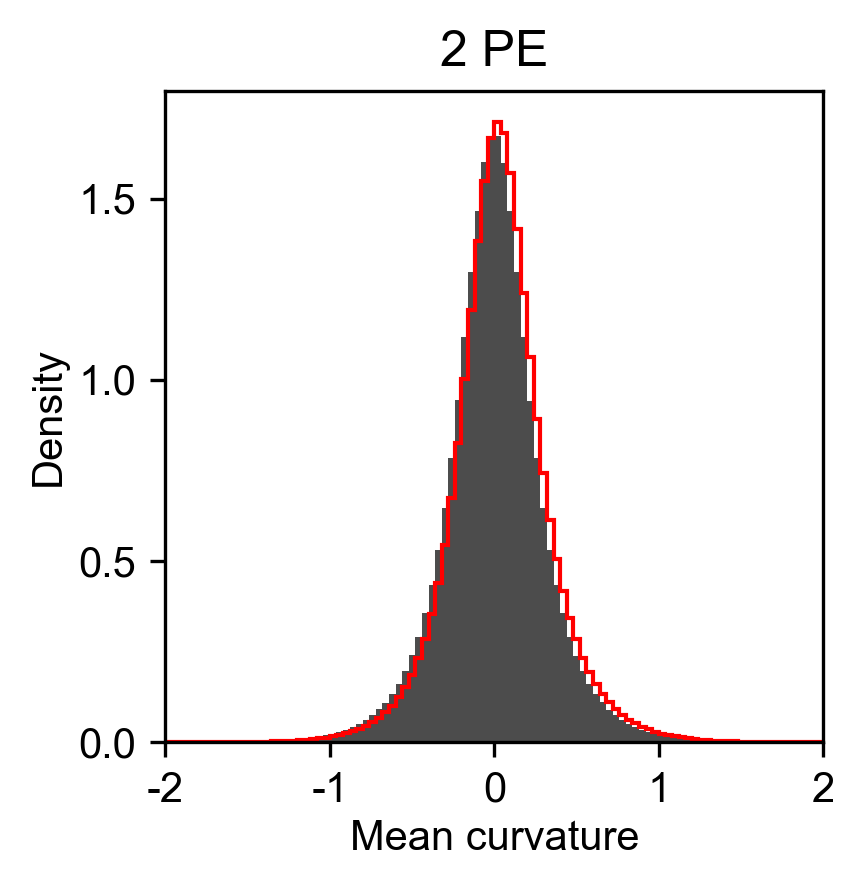

  0%|          | 0/10000 [00:00<?, ?it/s]

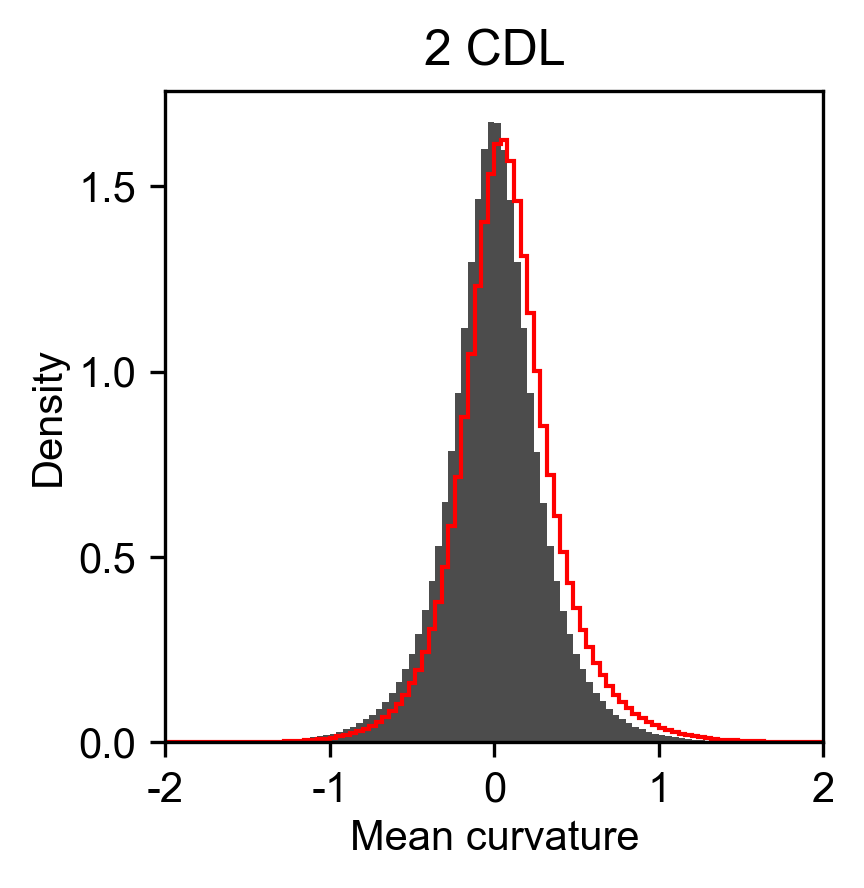

3


  0%|          | 0/10000 [00:00<?, ?it/s]

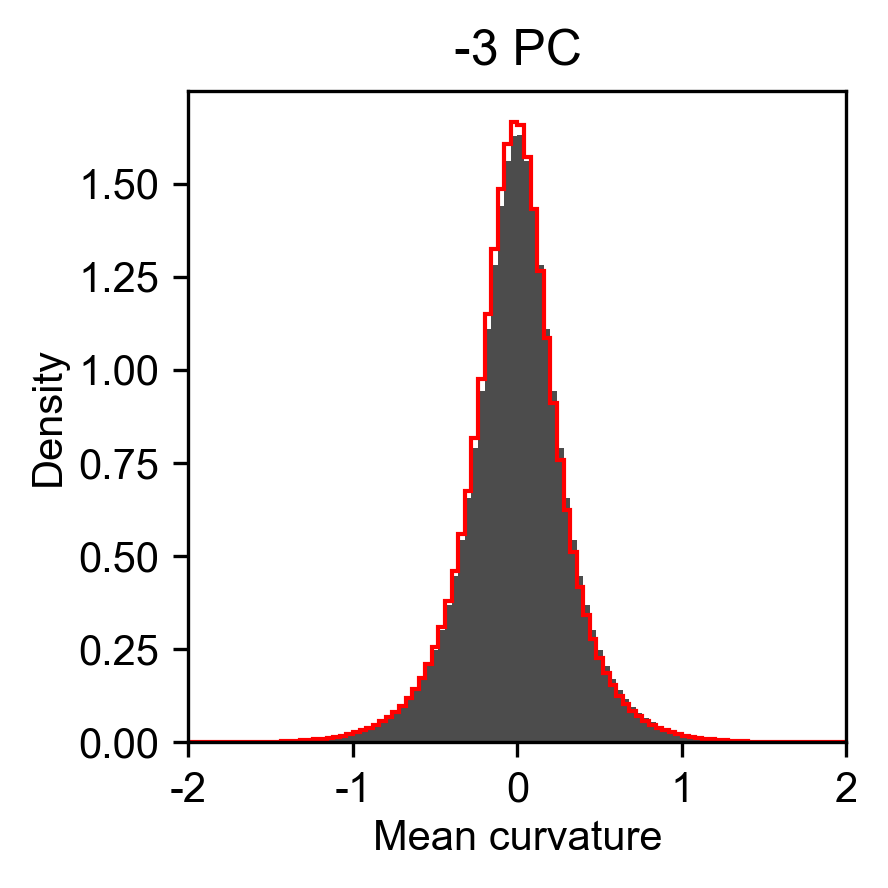

  0%|          | 0/10000 [00:00<?, ?it/s]

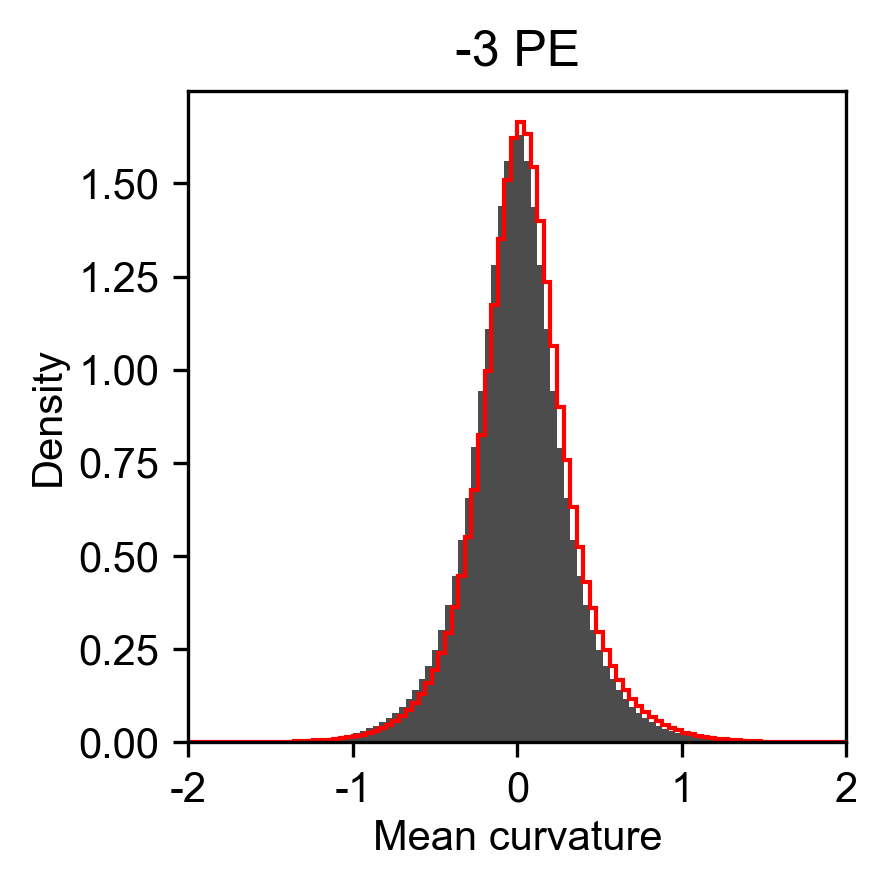

  0%|          | 0/10000 [00:00<?, ?it/s]

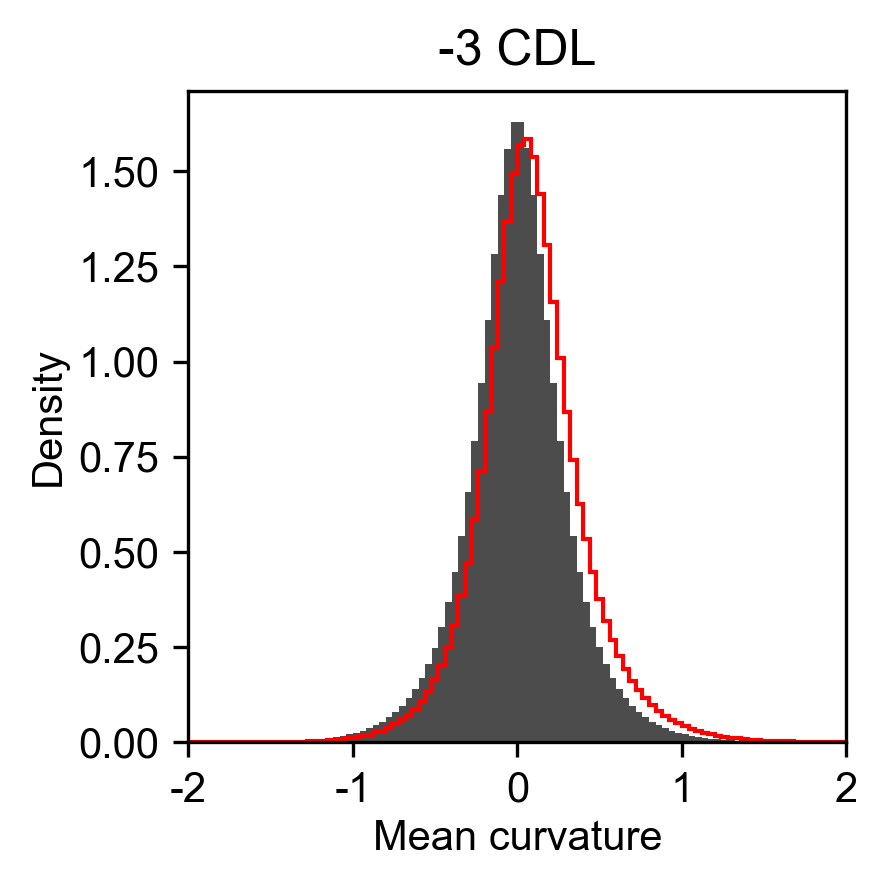

4


  0%|          | 0/10000 [00:00<?, ?it/s]

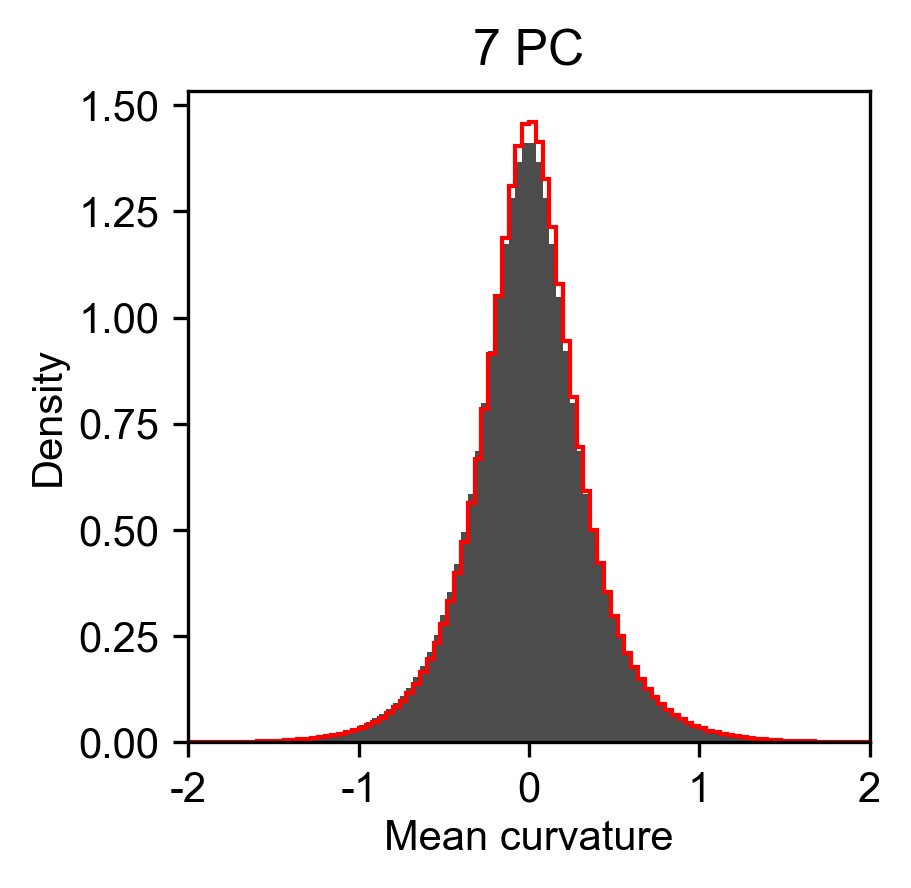

  0%|          | 0/10000 [00:00<?, ?it/s]

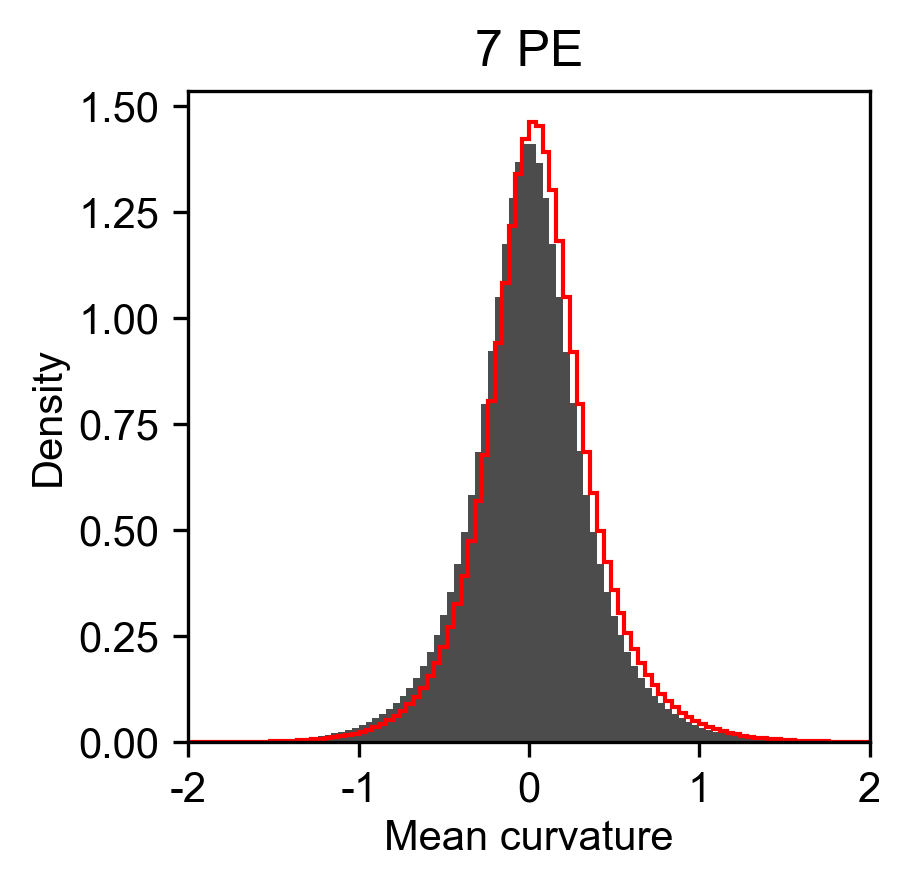

  0%|          | 0/10000 [00:00<?, ?it/s]

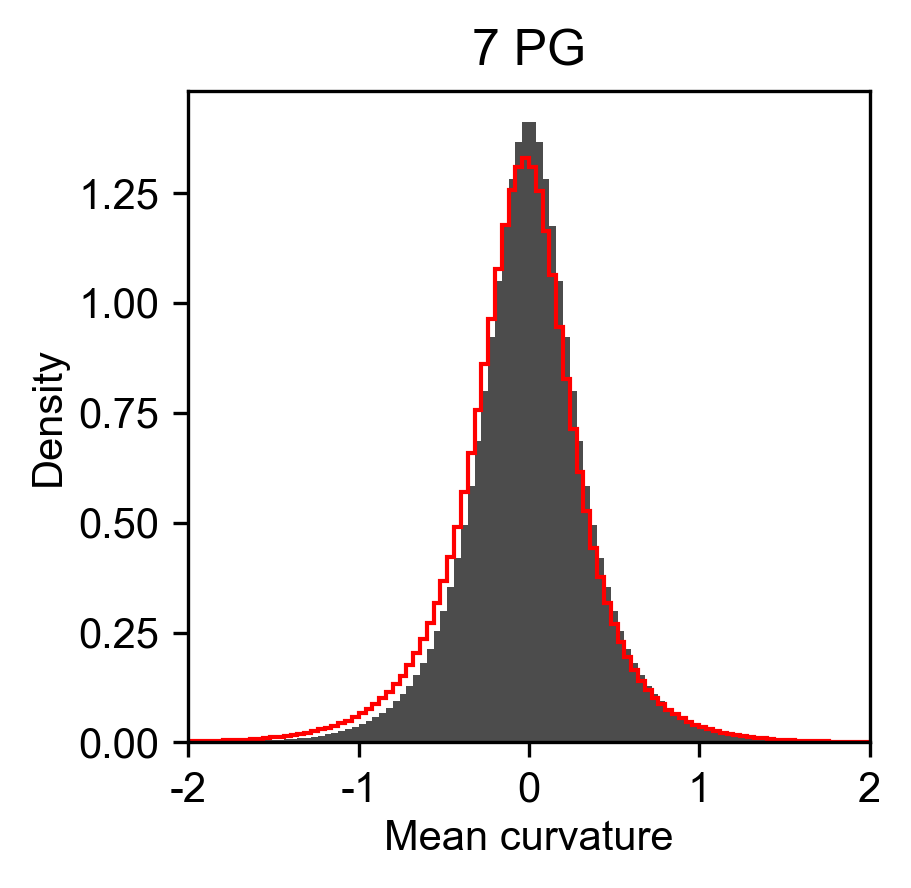

5


  0%|          | 0/10000 [00:00<?, ?it/s]

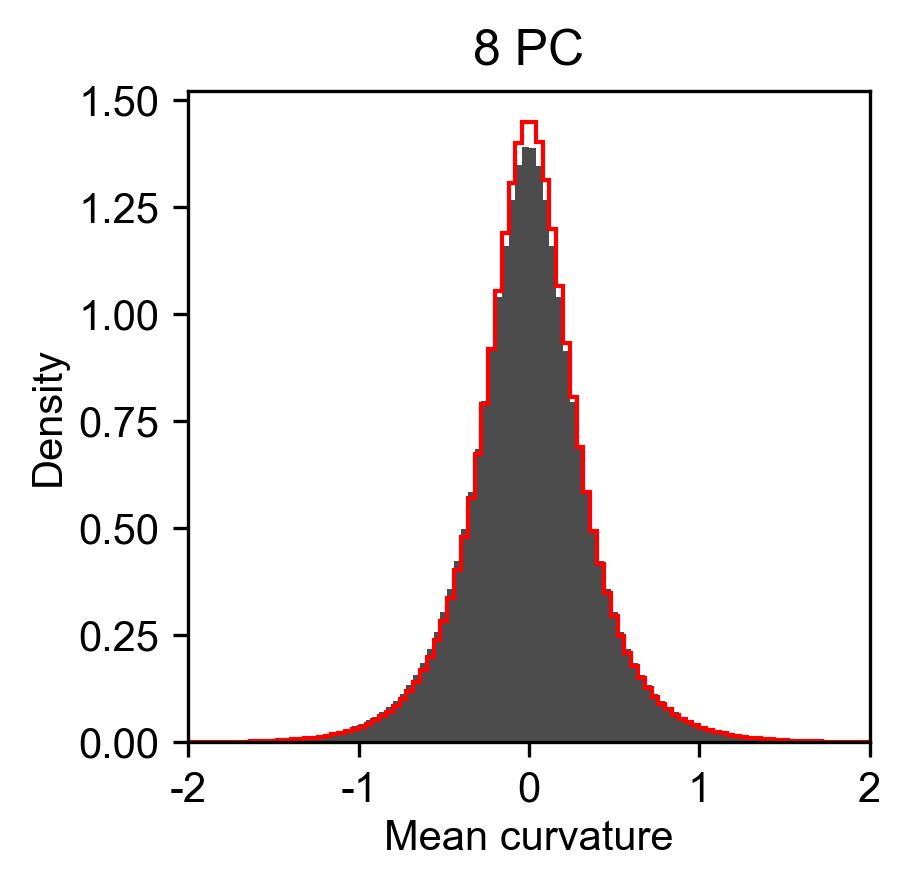

  0%|          | 0/10000 [00:00<?, ?it/s]

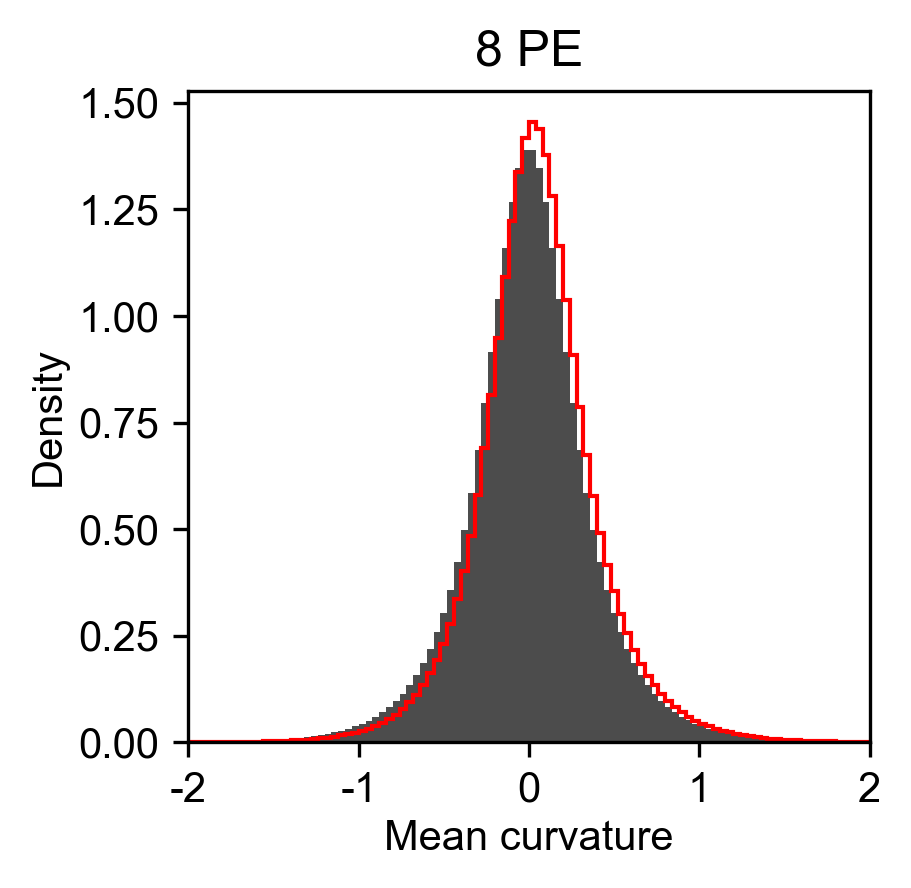

  0%|          | 0/10000 [00:00<?, ?it/s]

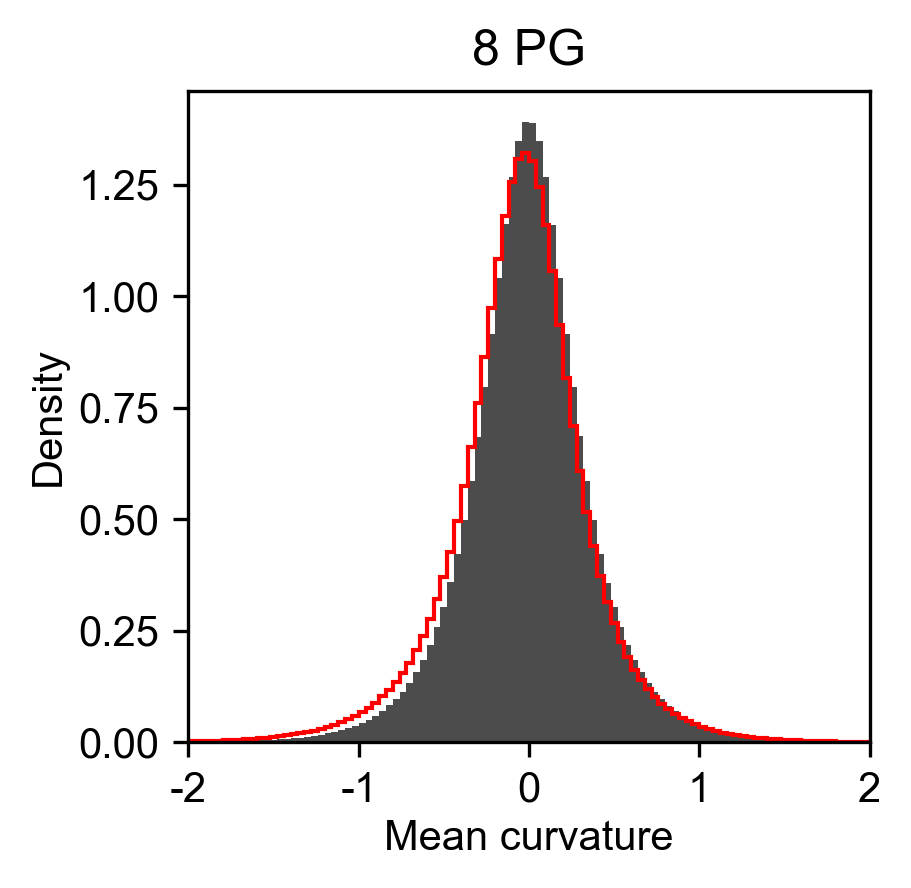

6


  0%|          | 0/10000 [00:00<?, ?it/s]

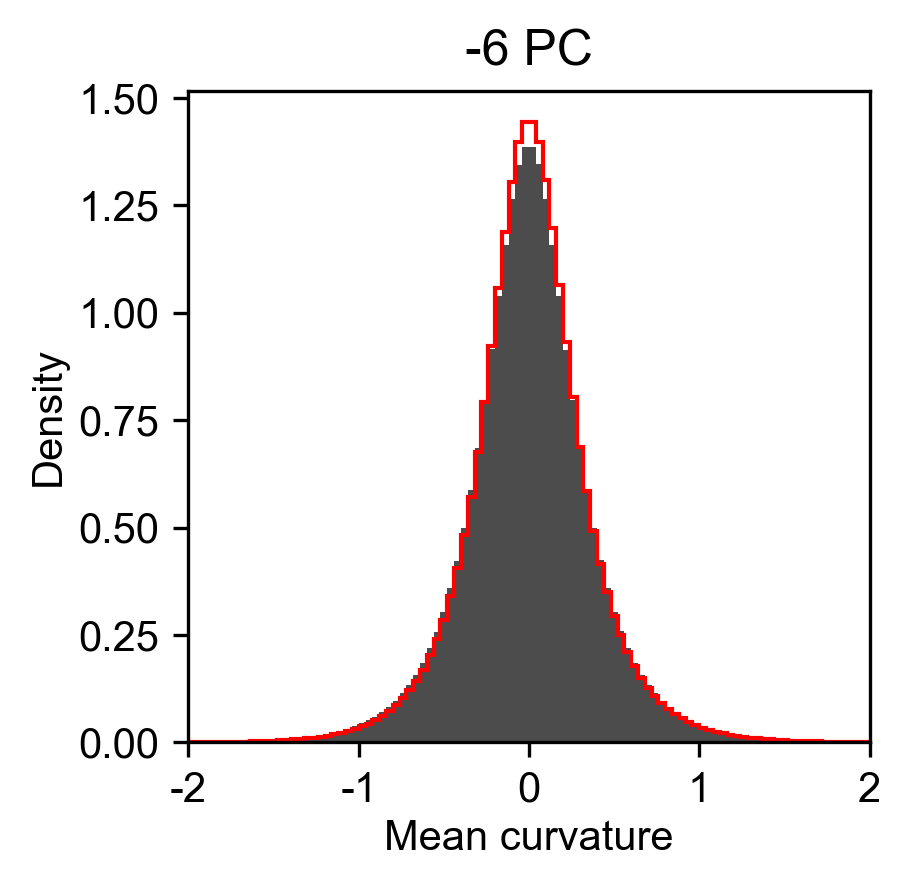

  0%|          | 0/10000 [00:00<?, ?it/s]

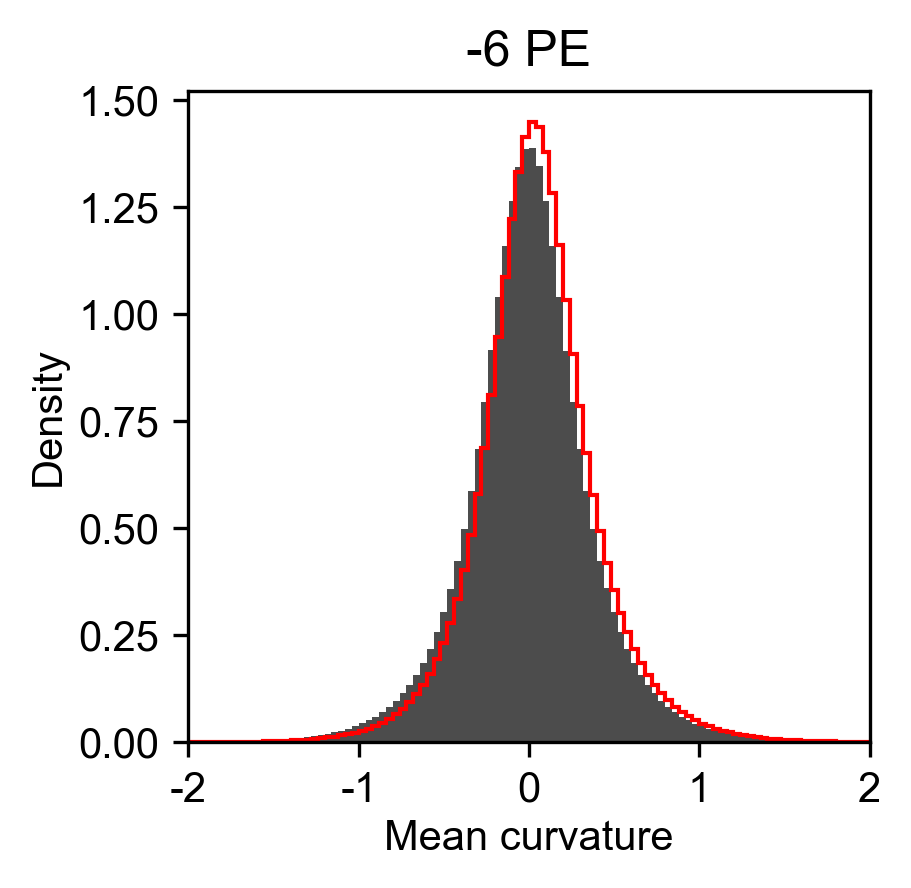

  0%|          | 0/10000 [00:00<?, ?it/s]

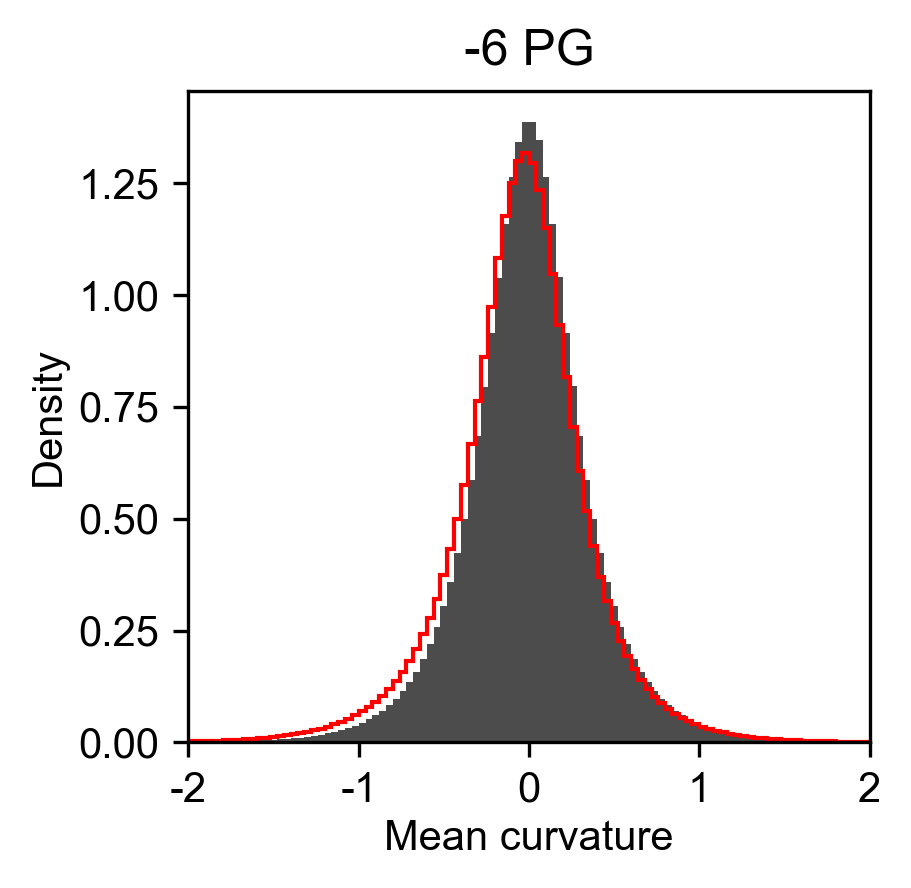

7


  0%|          | 0/10000 [00:00<?, ?it/s]

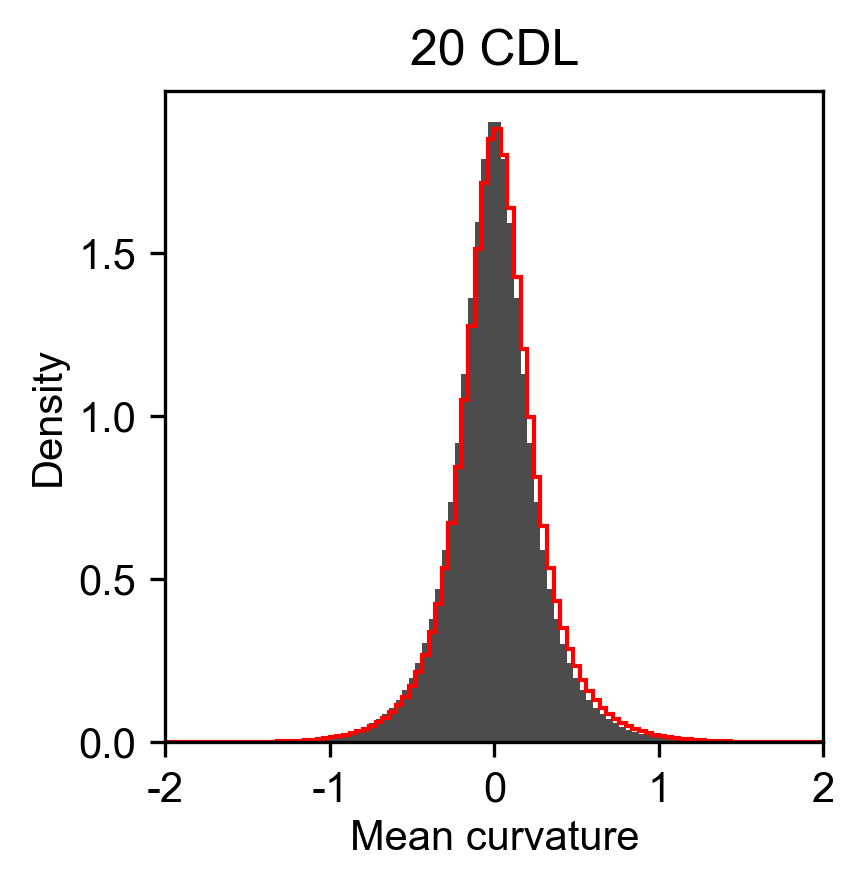

8


  0%|          | 0/10000 [00:00<?, ?it/s]

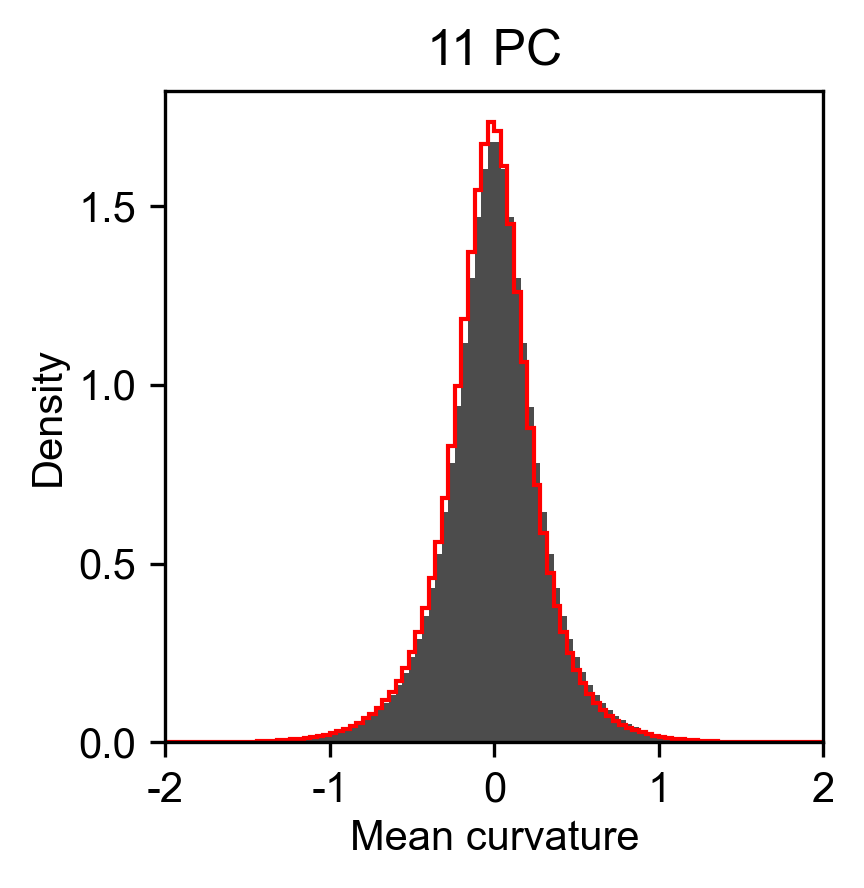

  0%|          | 0/10000 [00:00<?, ?it/s]

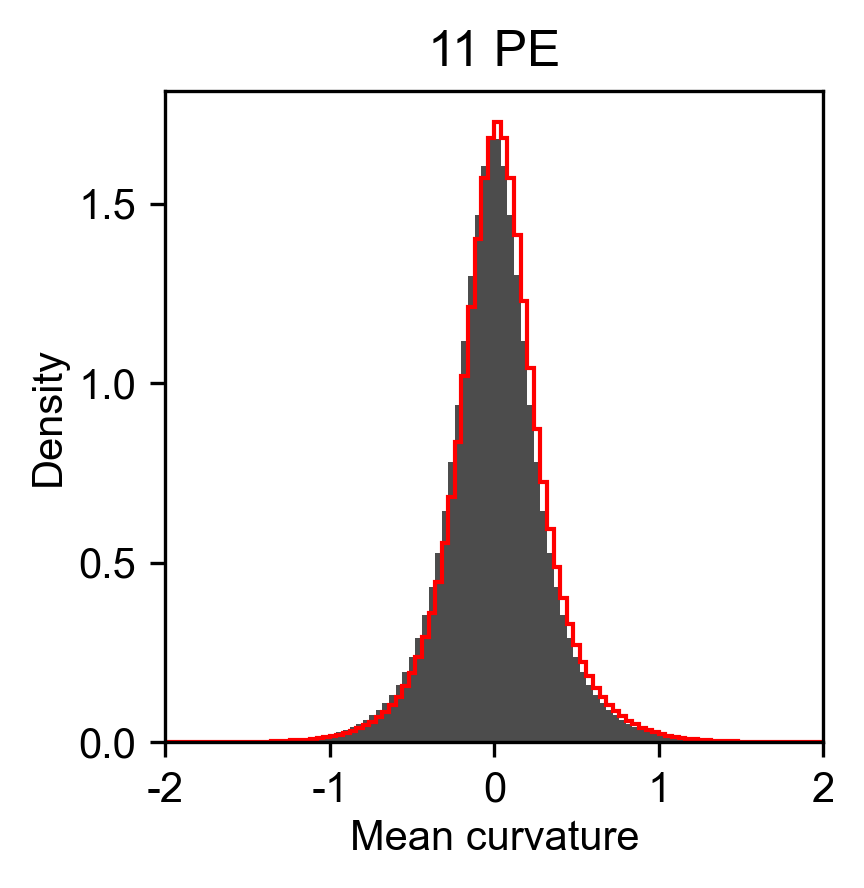

  0%|          | 0/10000 [00:00<?, ?it/s]

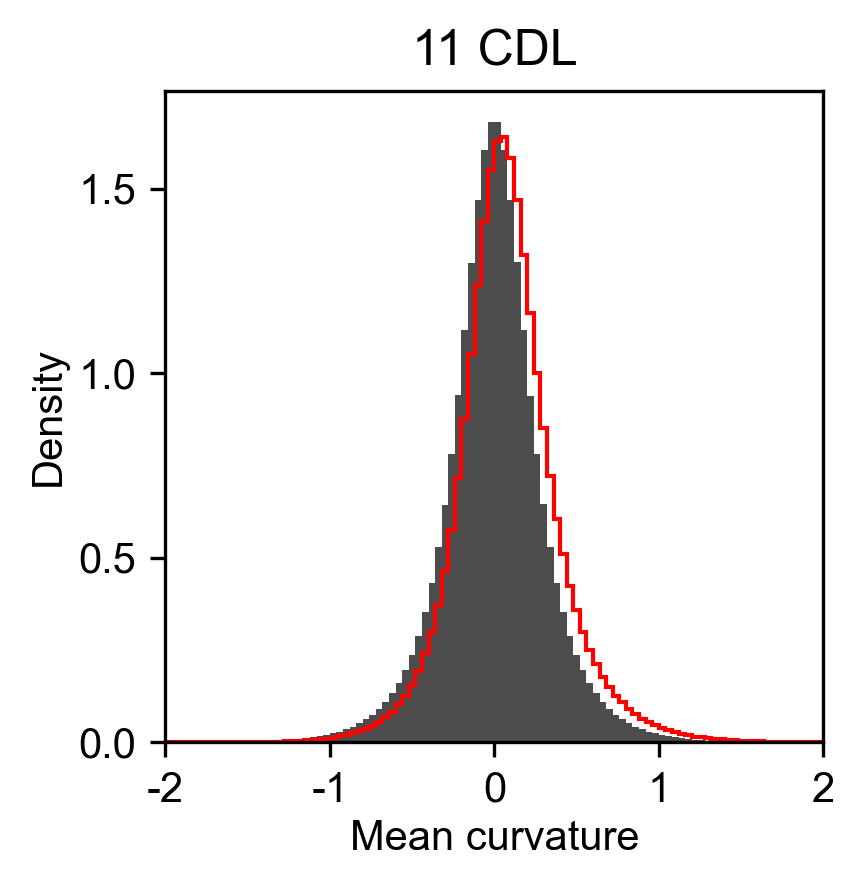

9


  0%|          | 0/10000 [00:00<?, ?it/s]

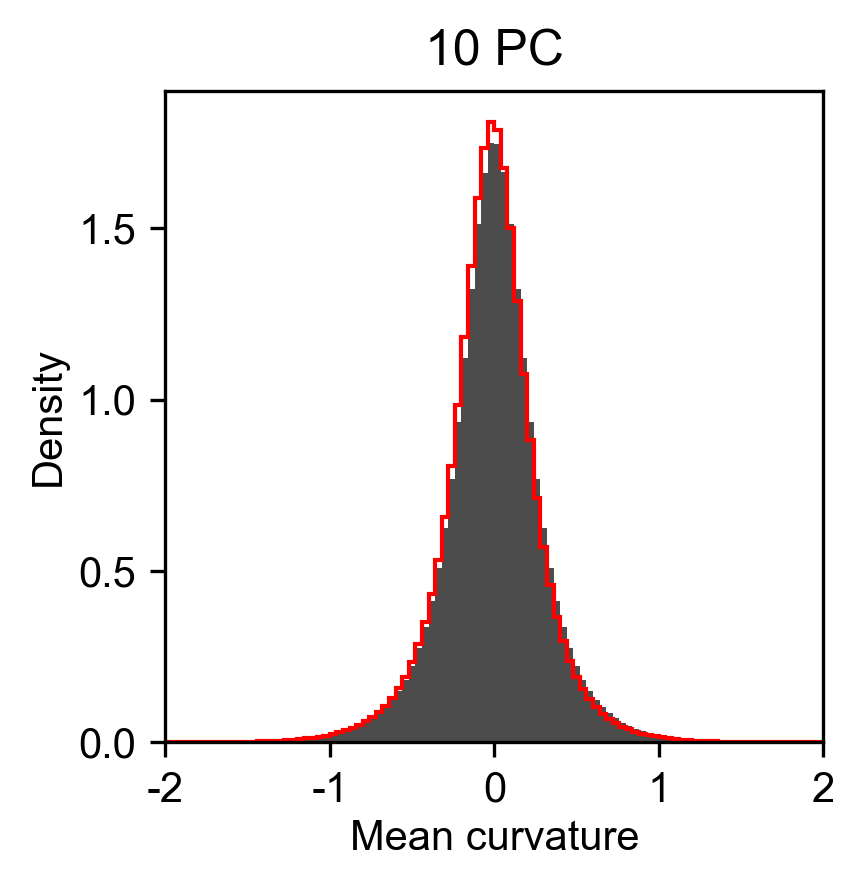

  0%|          | 0/10000 [00:00<?, ?it/s]

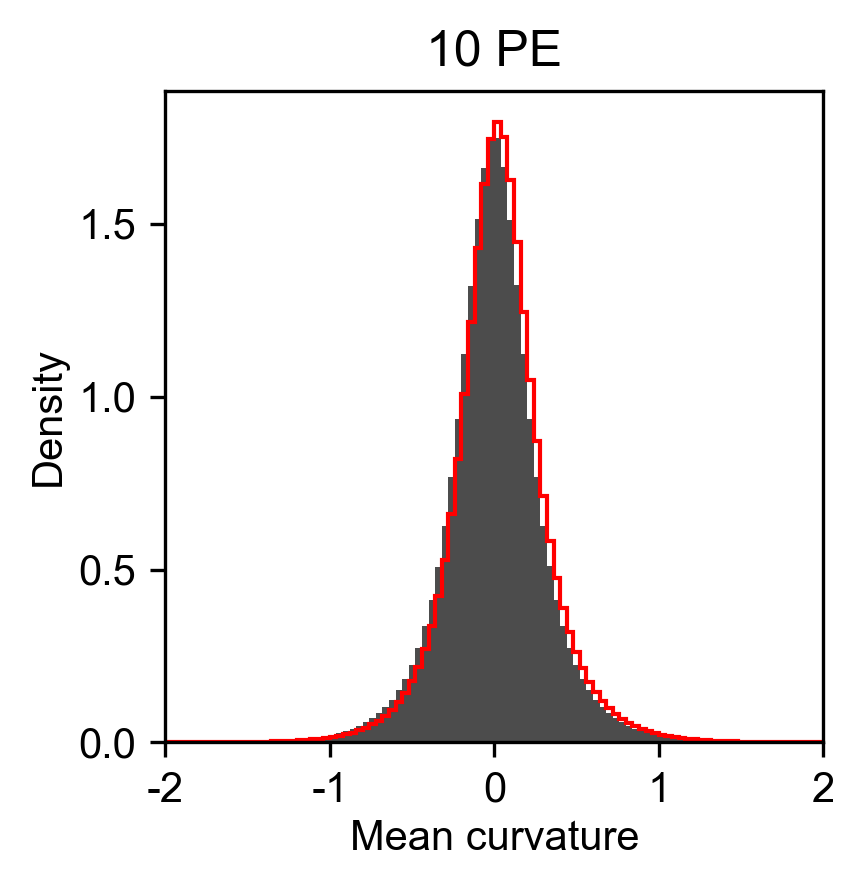

  0%|          | 0/10000 [00:00<?, ?it/s]

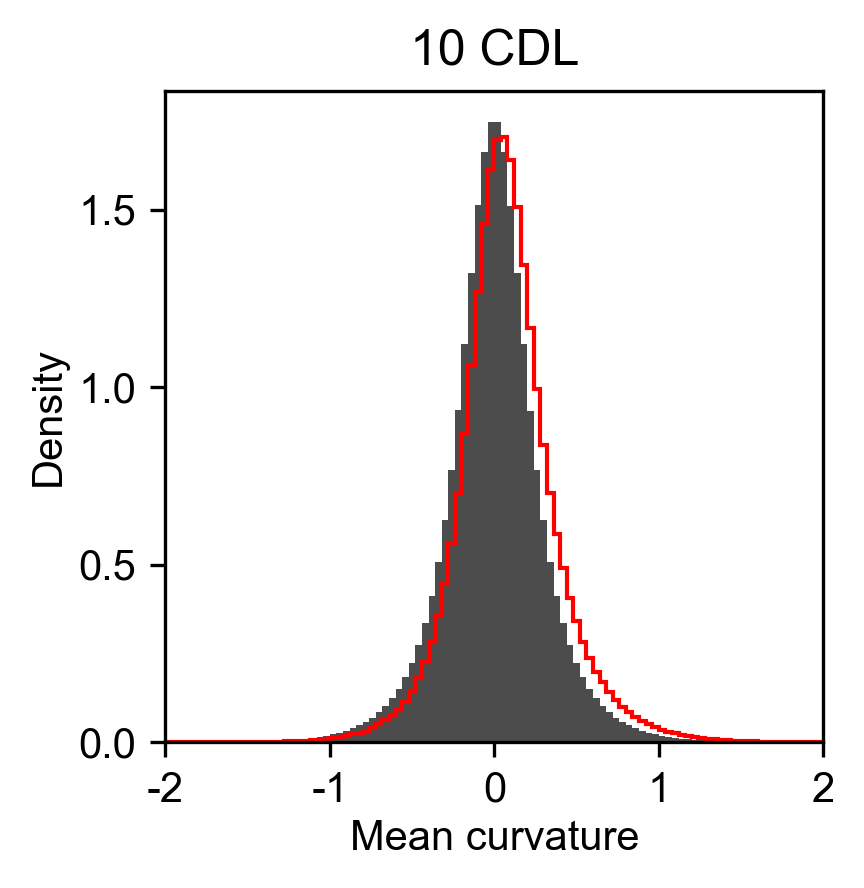

10


  0%|          | 0/10000 [00:00<?, ?it/s]

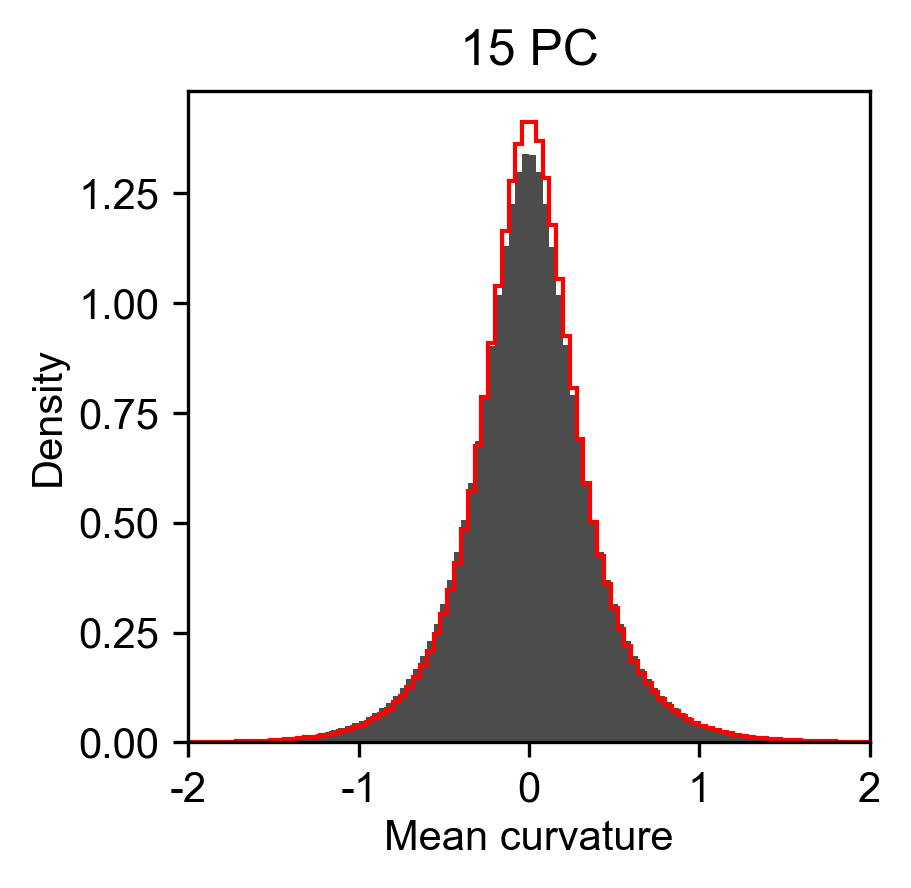

  0%|          | 0/10000 [00:00<?, ?it/s]

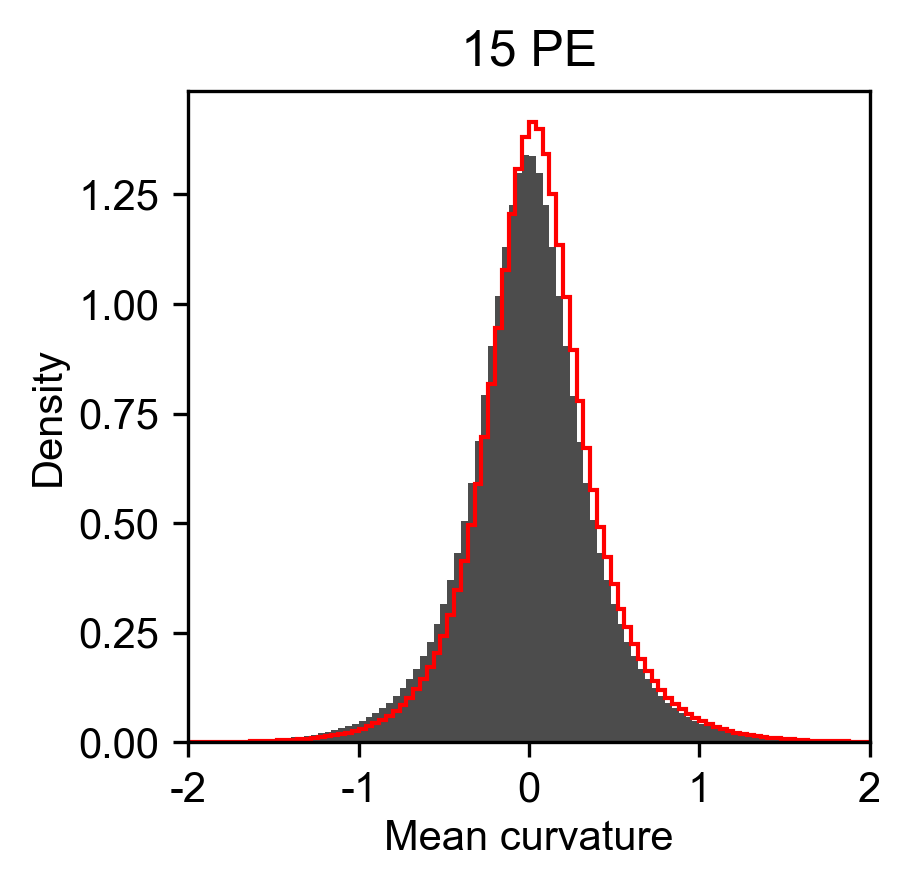

  0%|          | 0/10000 [00:00<?, ?it/s]

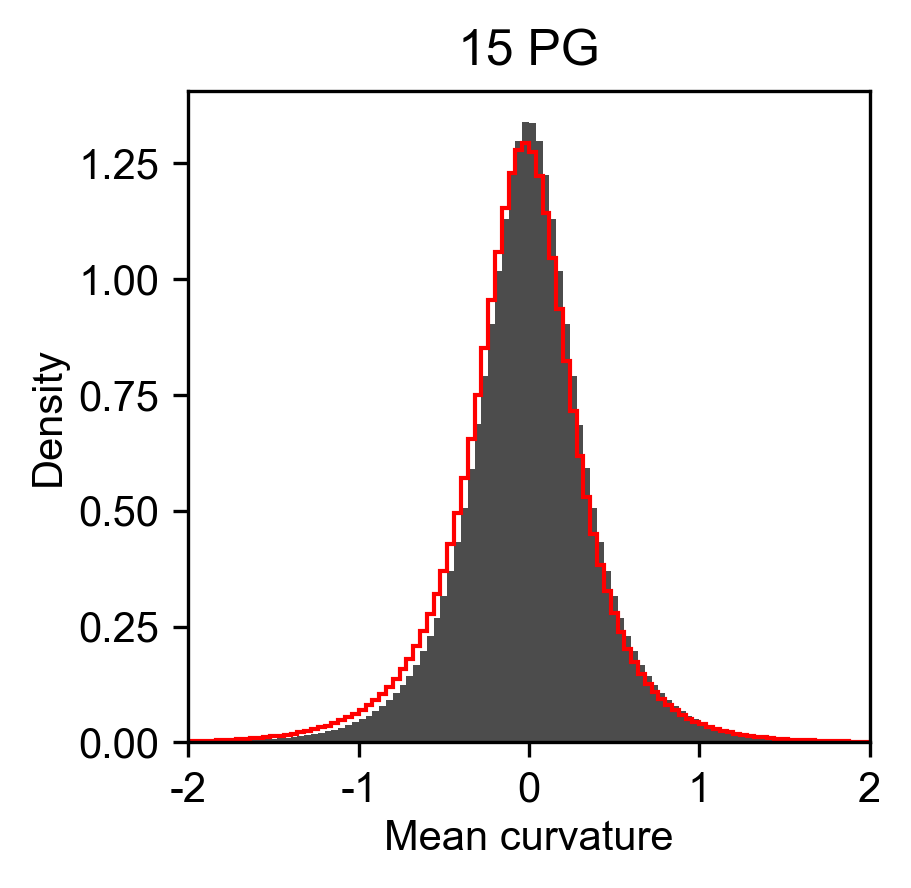

11


  0%|          | 0/10000 [00:00<?, ?it/s]

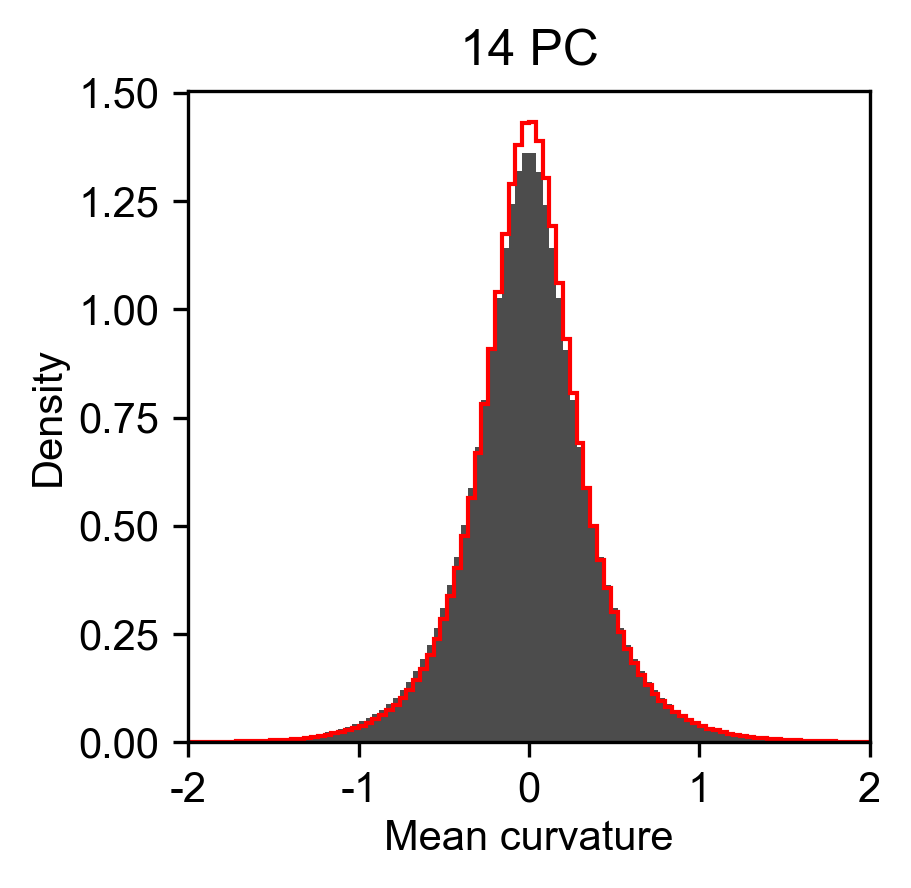

  0%|          | 0/10000 [00:00<?, ?it/s]

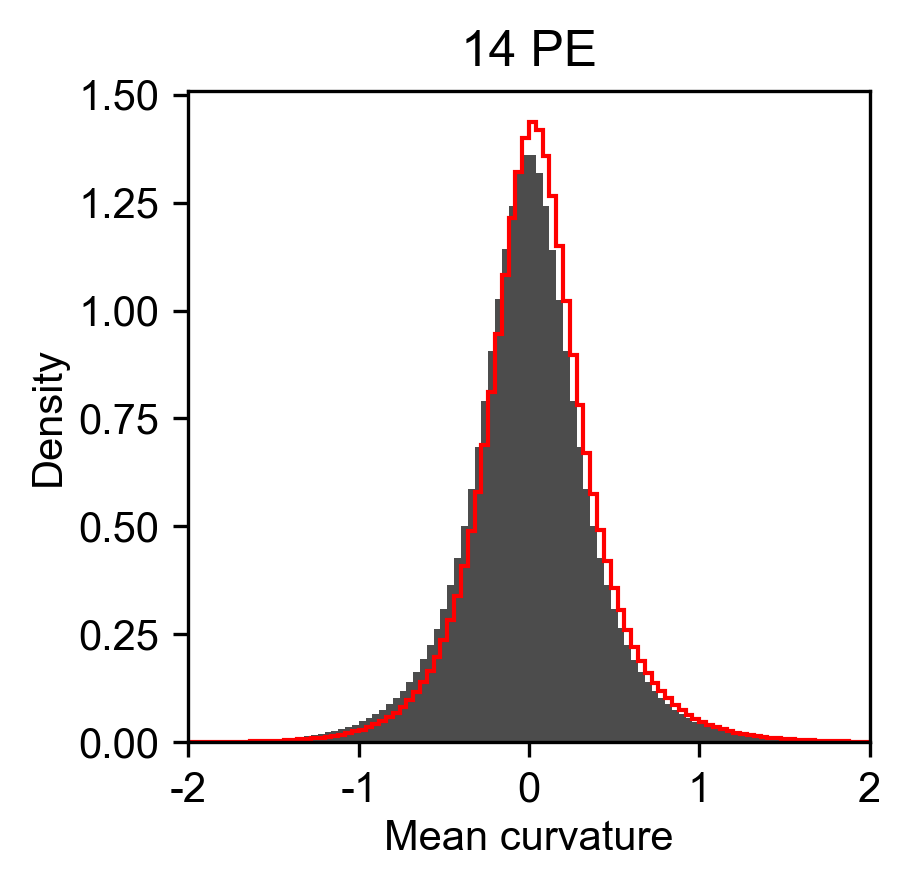

  0%|          | 0/10000 [00:00<?, ?it/s]

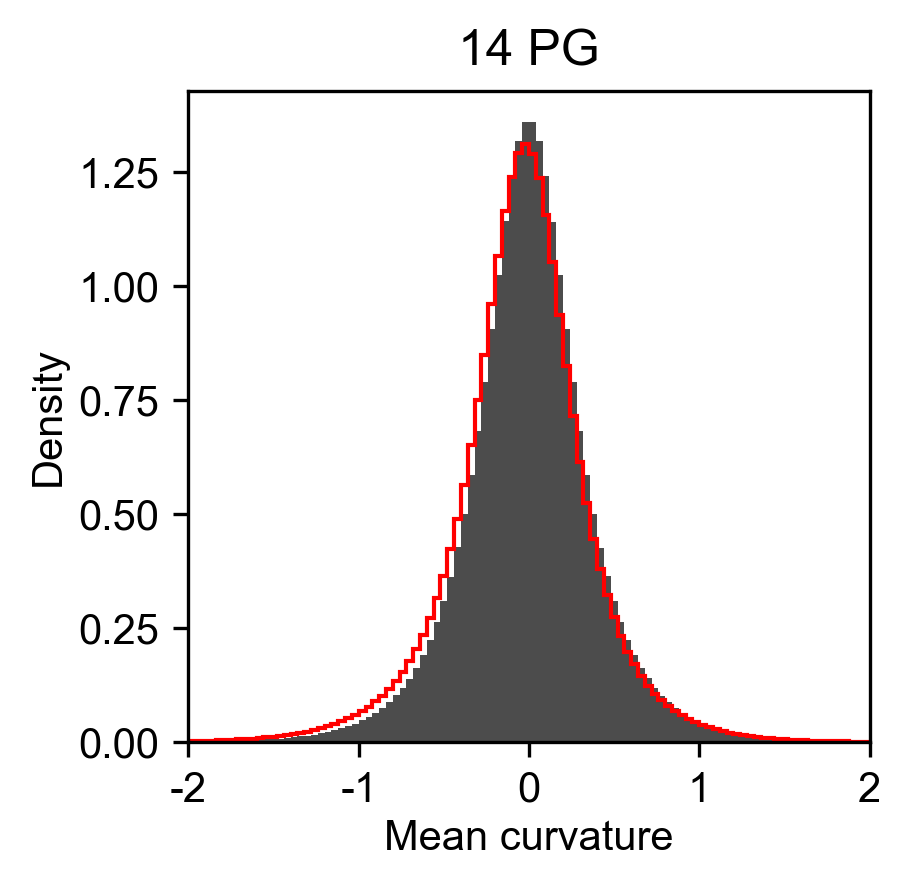

12


  0%|          | 0/10000 [00:00<?, ?it/s]

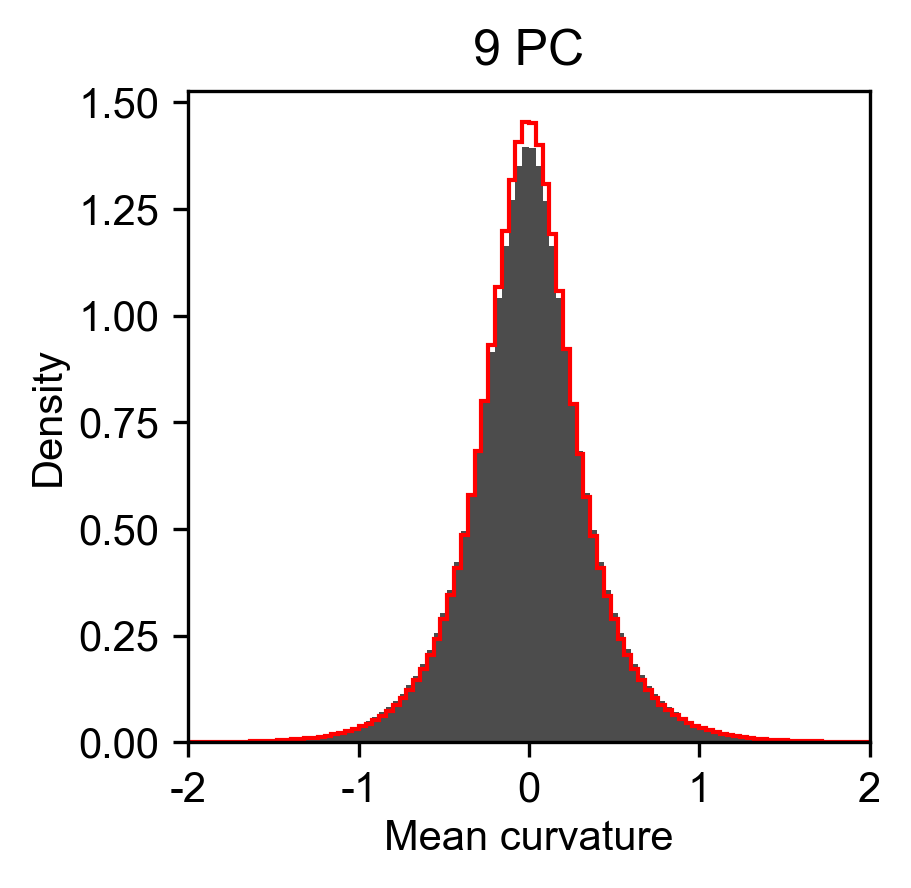

  0%|          | 0/10000 [00:00<?, ?it/s]

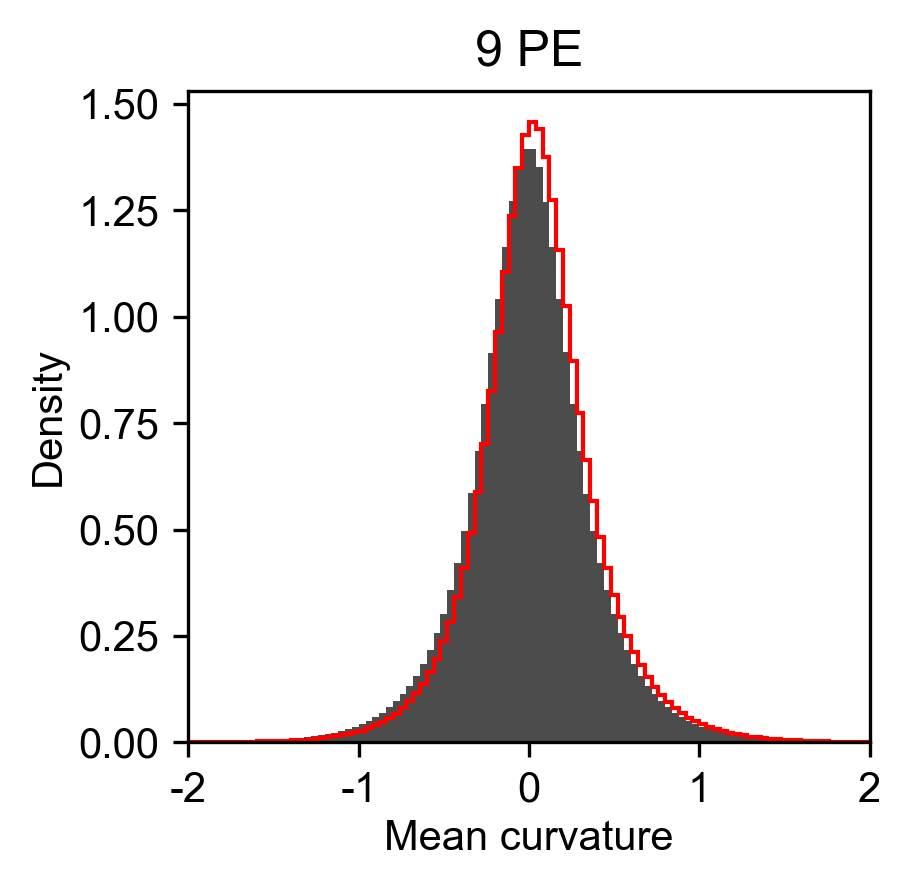

  0%|          | 0/10000 [00:00<?, ?it/s]

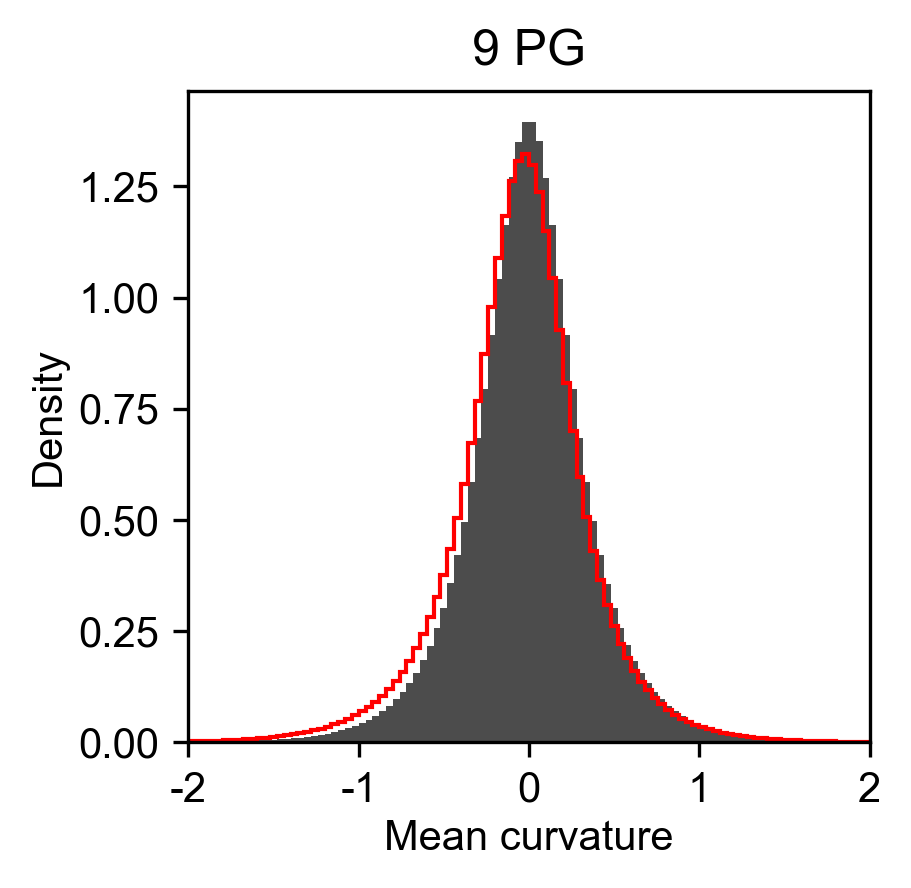

13


  0%|          | 0/10000 [00:00<?, ?it/s]

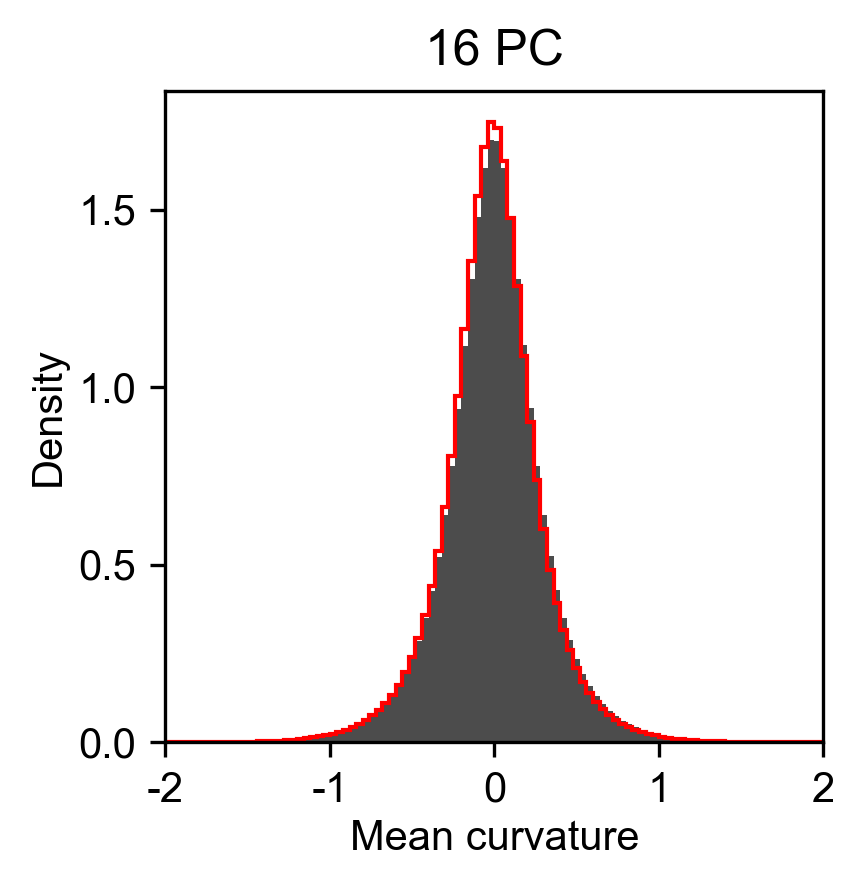

  0%|          | 0/10000 [00:00<?, ?it/s]

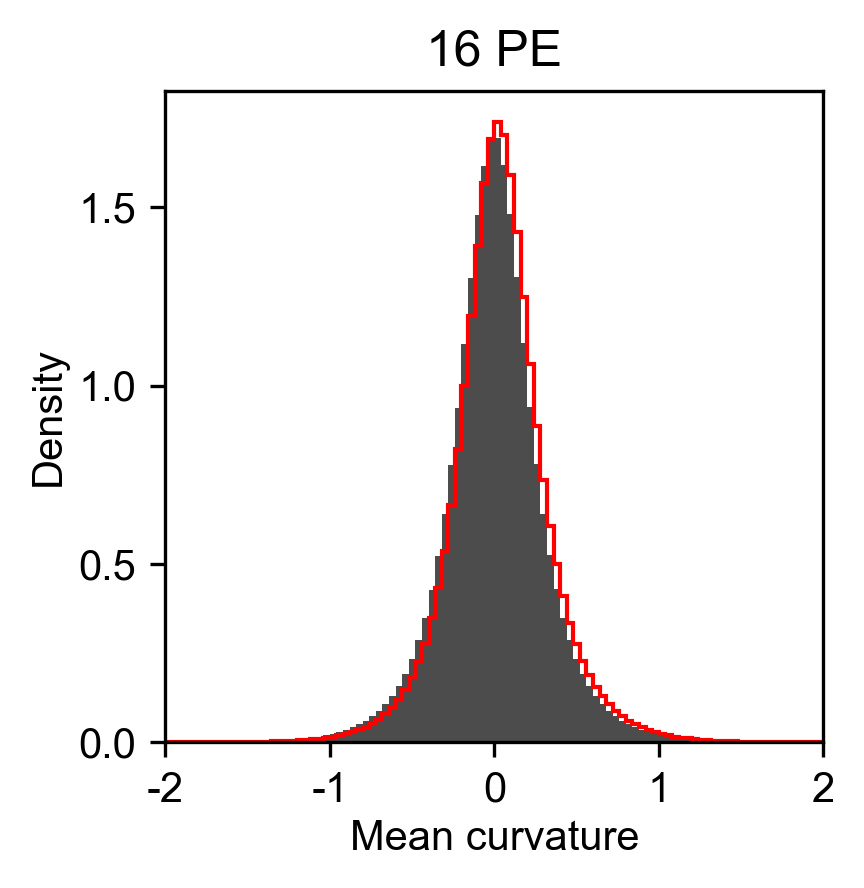

  0%|          | 0/10000 [00:00<?, ?it/s]

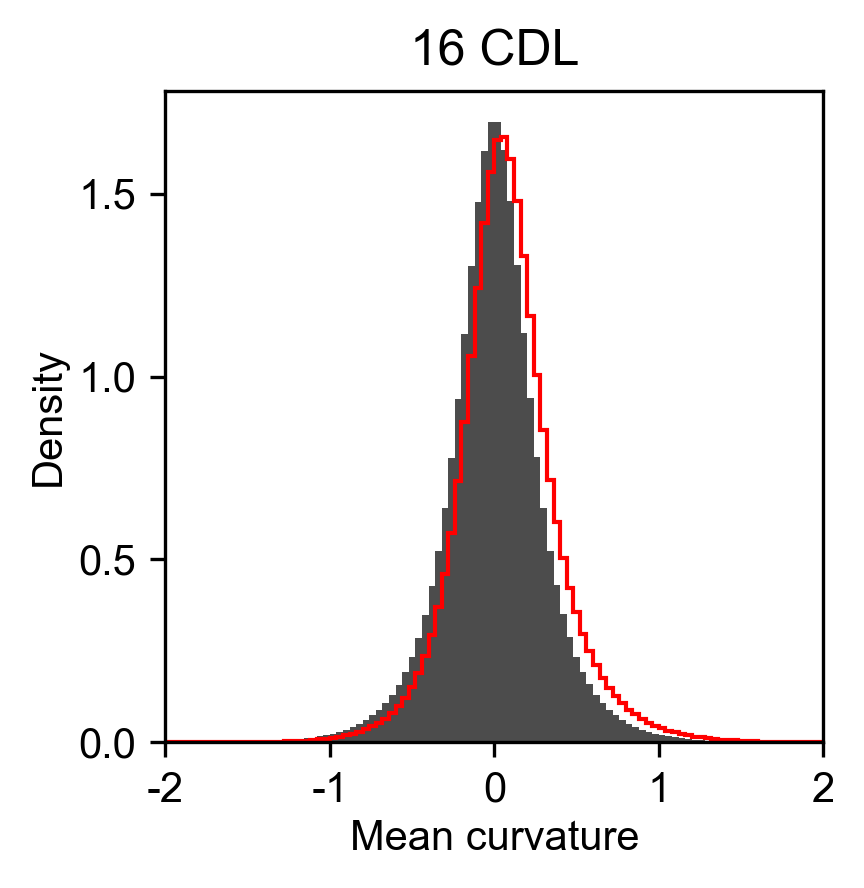

14


  0%|          | 0/10000 [00:00<?, ?it/s]

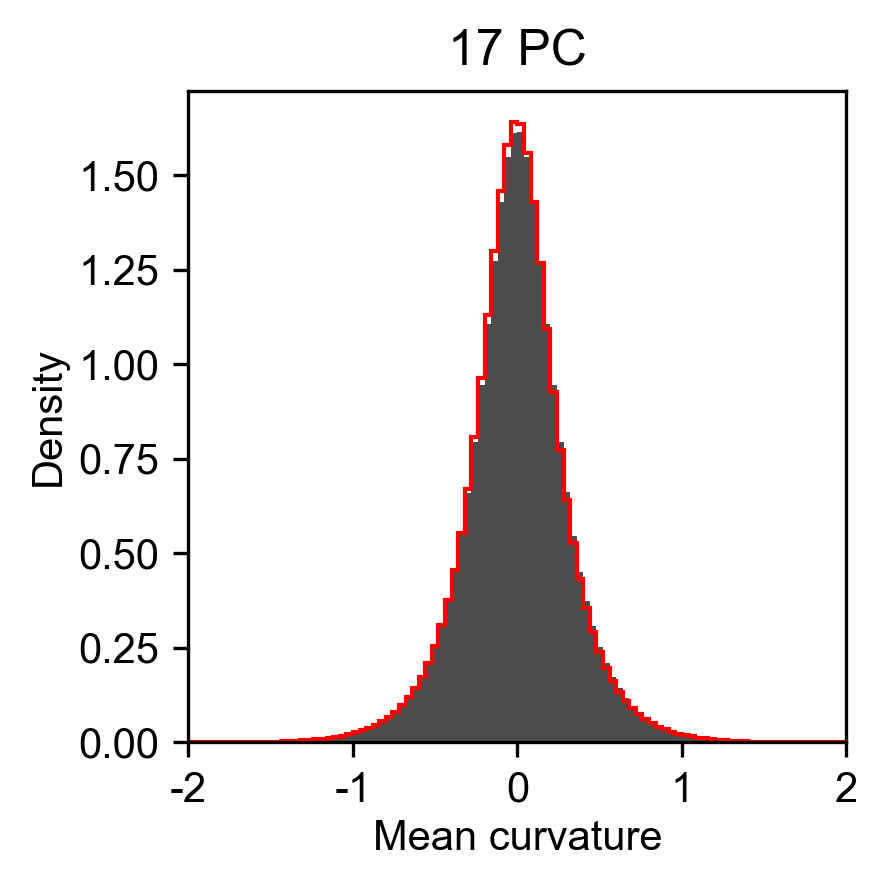

  0%|          | 0/10000 [00:00<?, ?it/s]

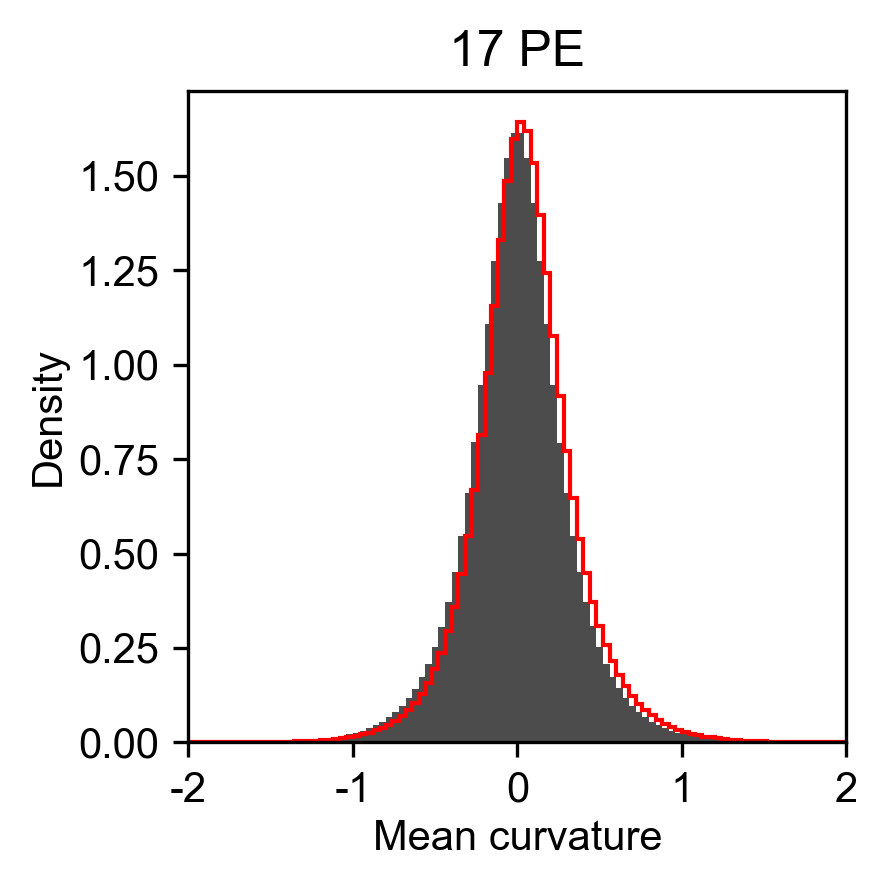

  0%|          | 0/10000 [00:00<?, ?it/s]

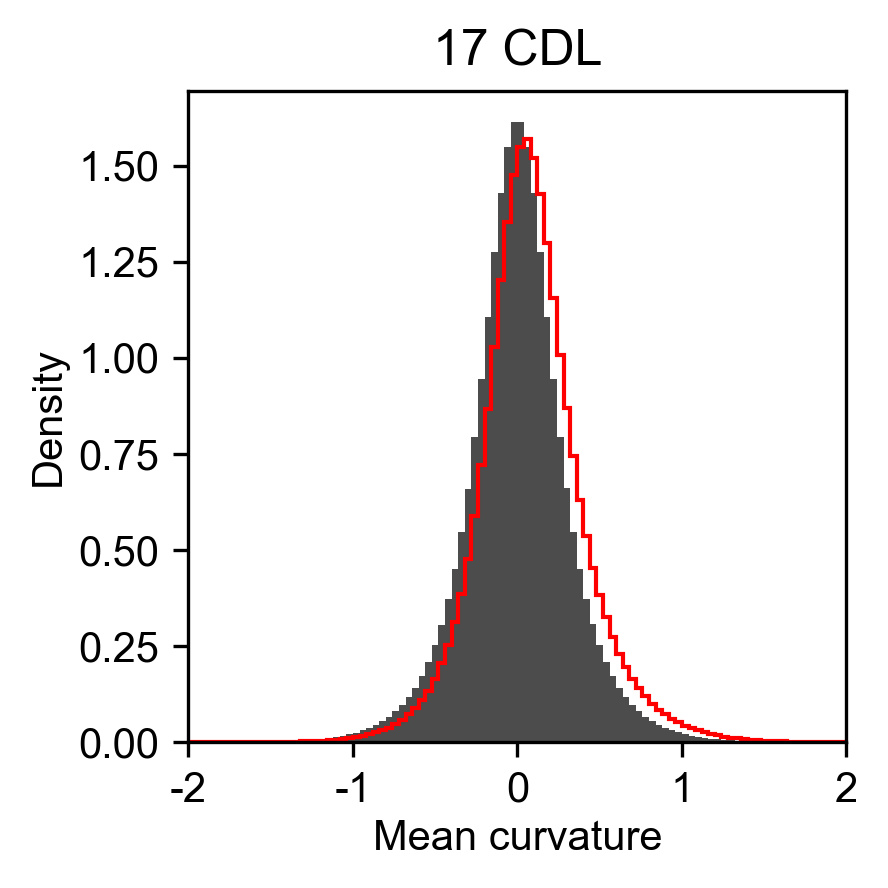

15


  0%|          | 0/10000 [00:00<?, ?it/s]

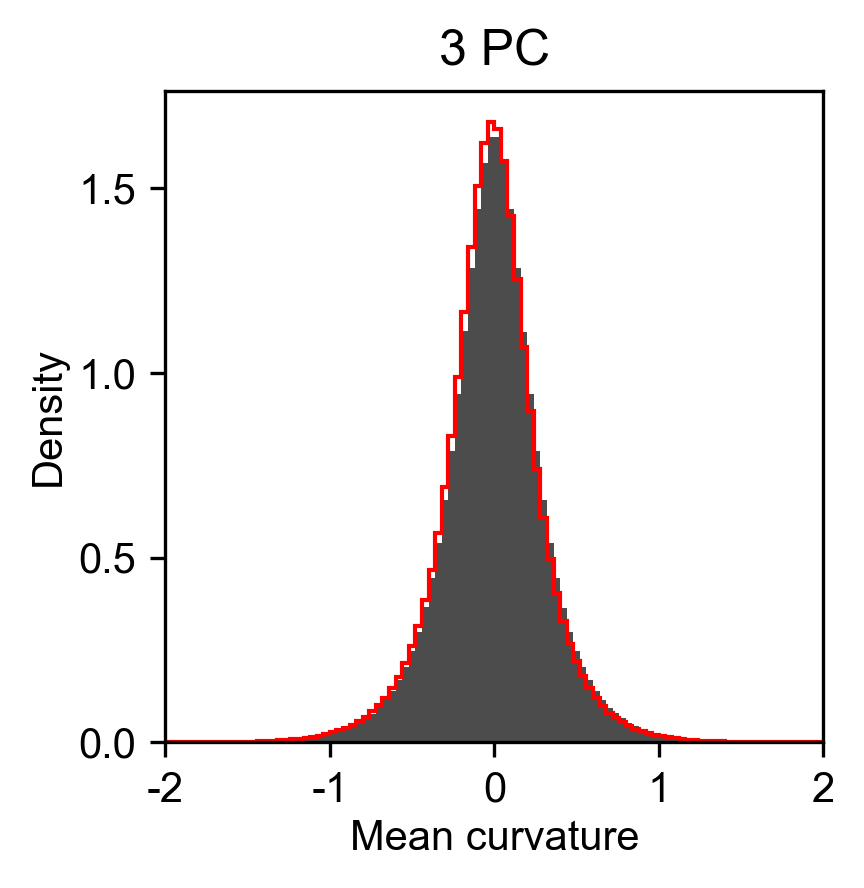

  0%|          | 0/10000 [00:00<?, ?it/s]

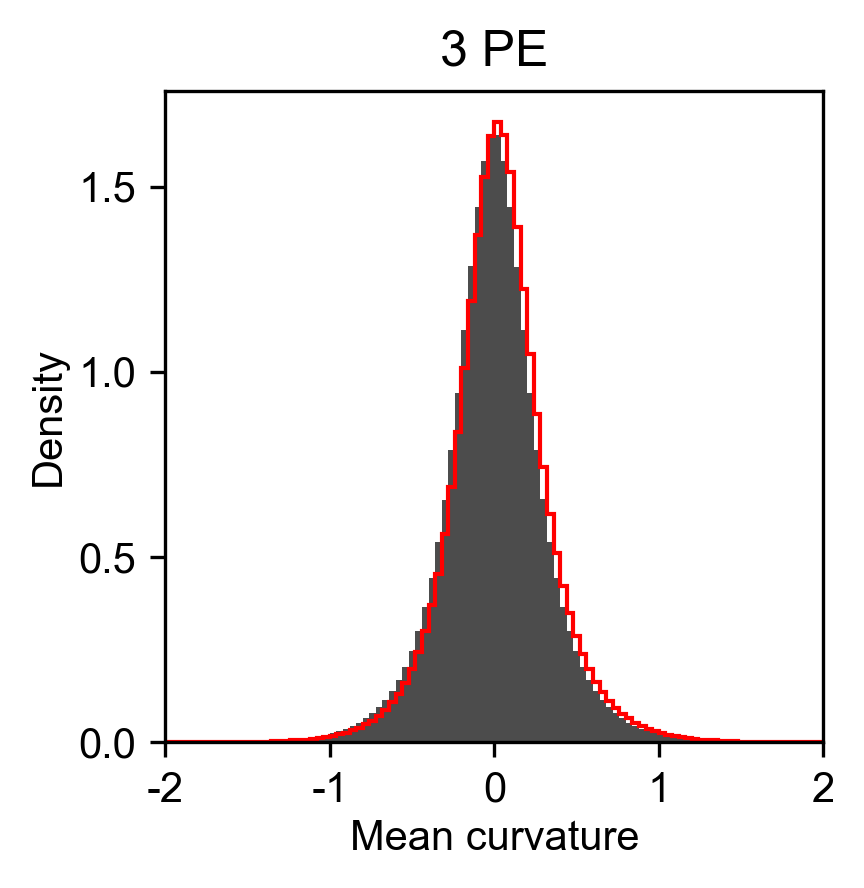

  0%|          | 0/10000 [00:00<?, ?it/s]

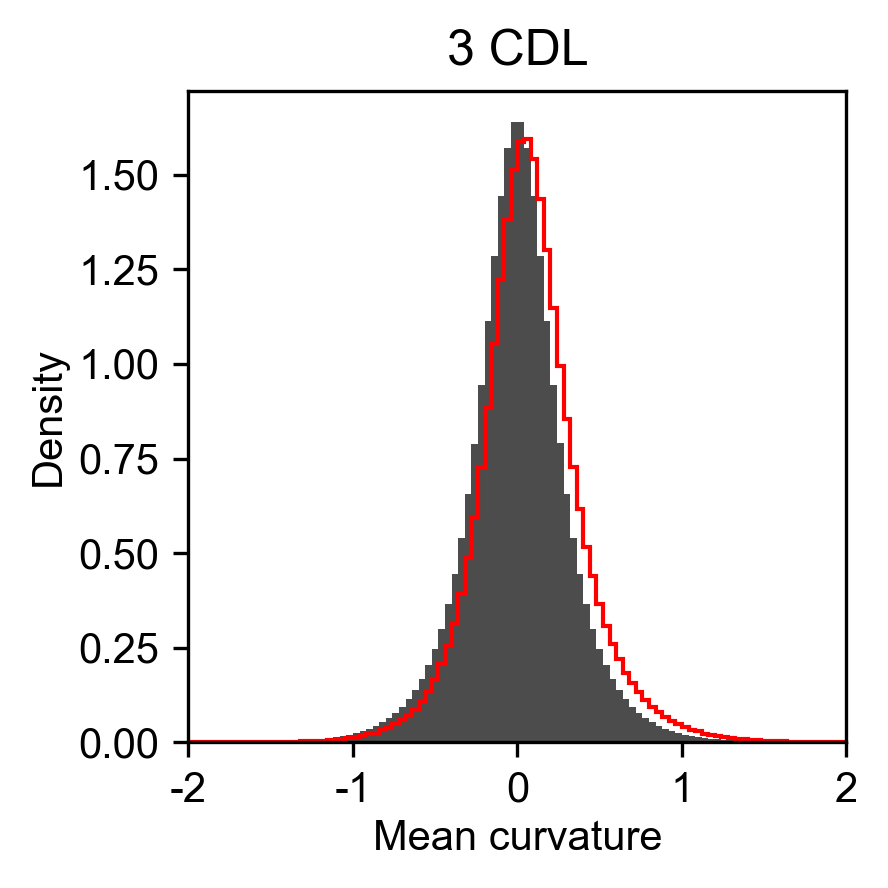

16


  0%|          | 0/10000 [00:00<?, ?it/s]

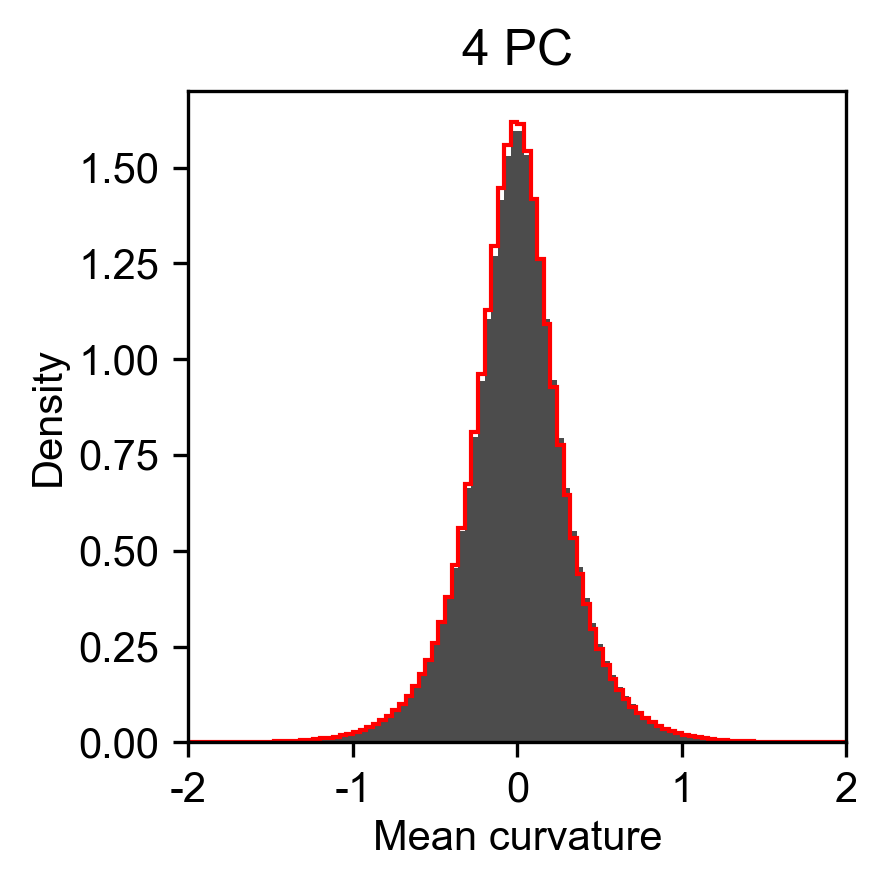

  0%|          | 0/10000 [00:00<?, ?it/s]

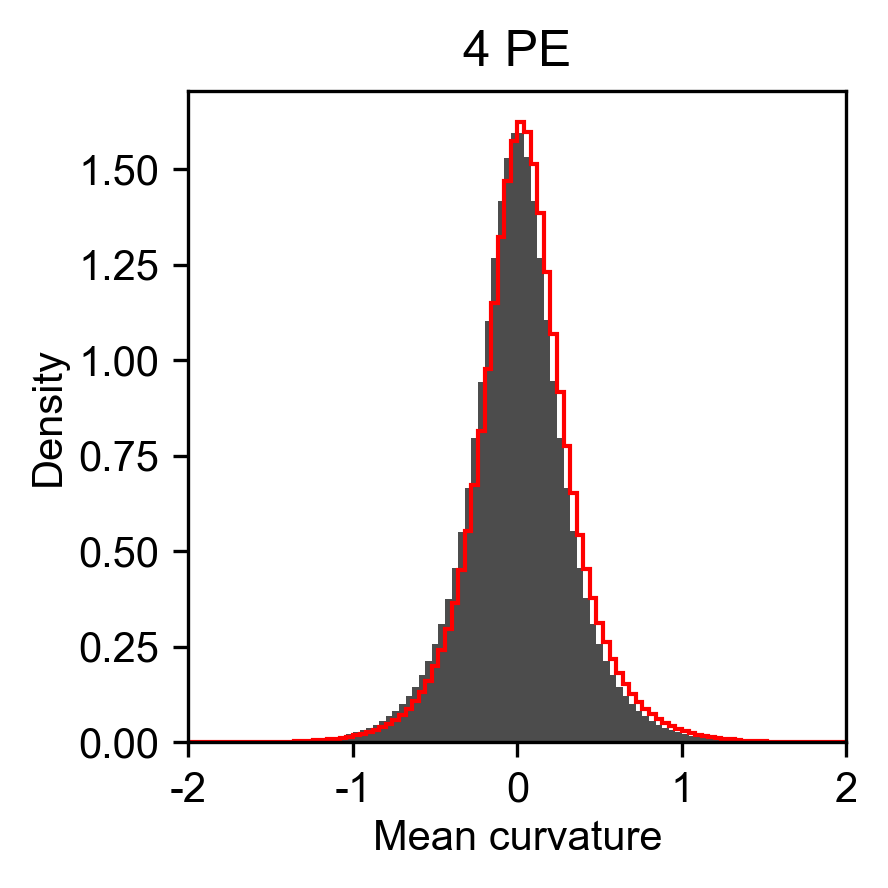

  0%|          | 0/10000 [00:00<?, ?it/s]

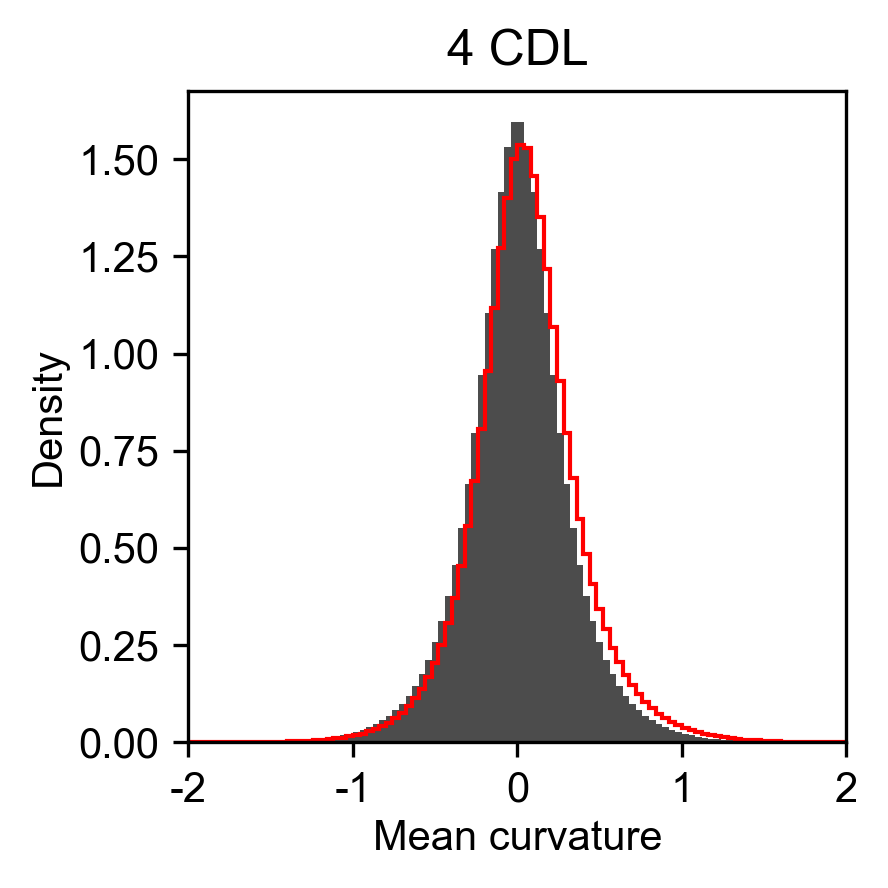

17


  0%|          | 0/10000 [00:00<?, ?it/s]

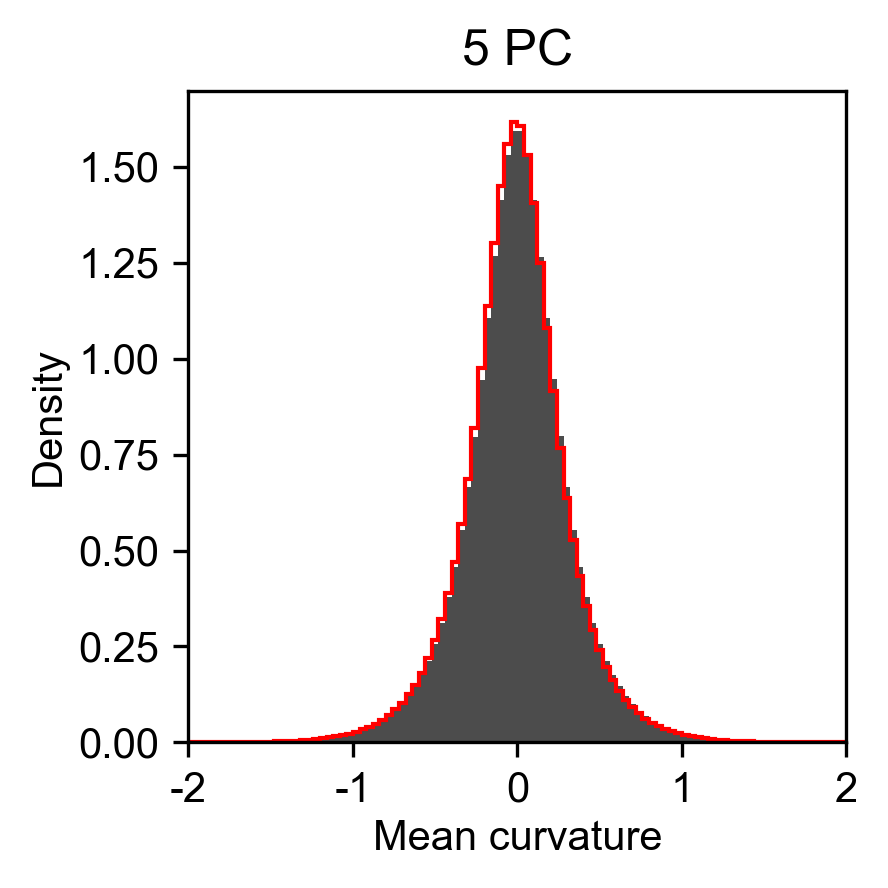

  0%|          | 0/10000 [00:00<?, ?it/s]

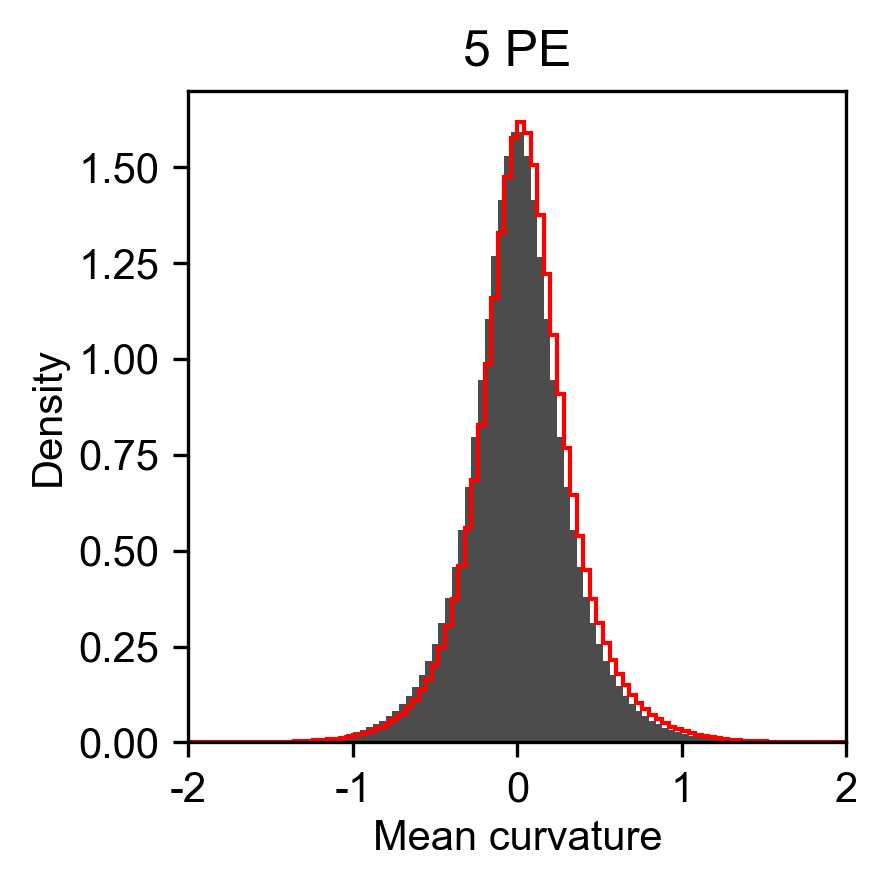

  0%|          | 0/10000 [00:00<?, ?it/s]

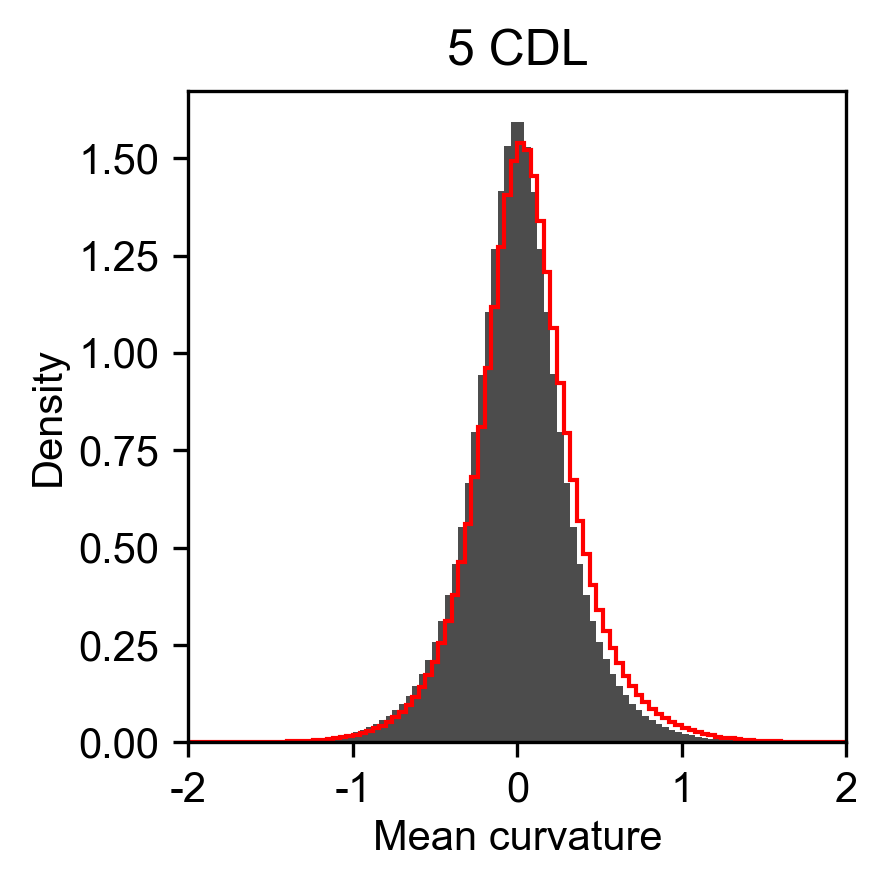

18


  0%|          | 0/10000 [00:00<?, ?it/s]

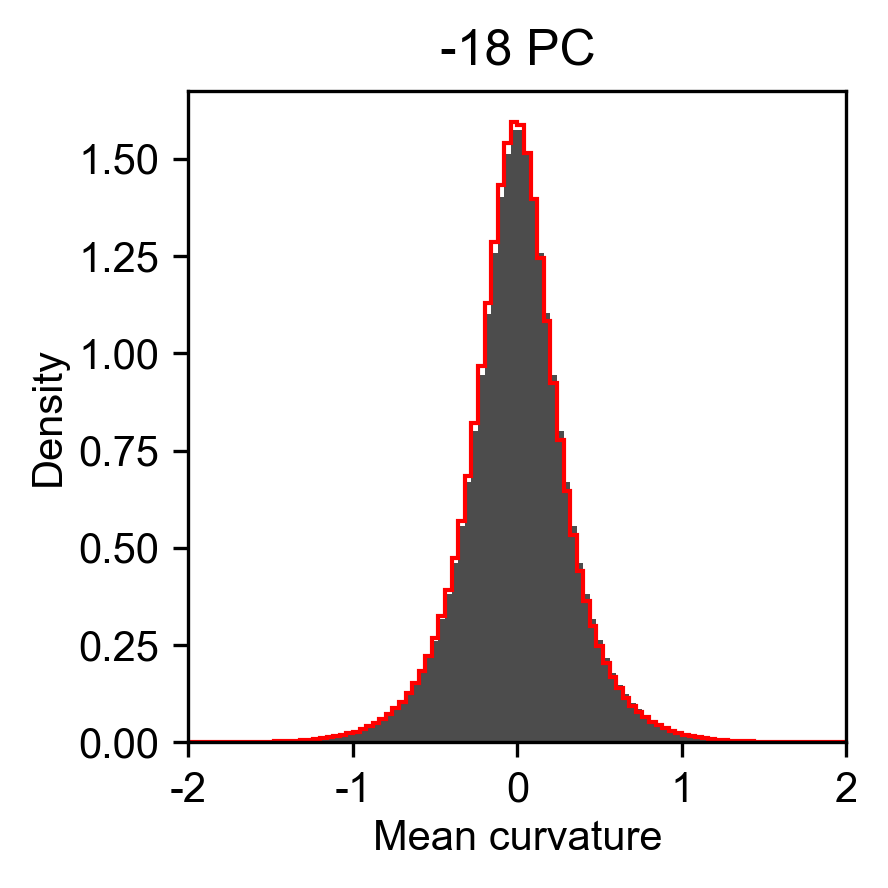

  0%|          | 0/10000 [00:00<?, ?it/s]

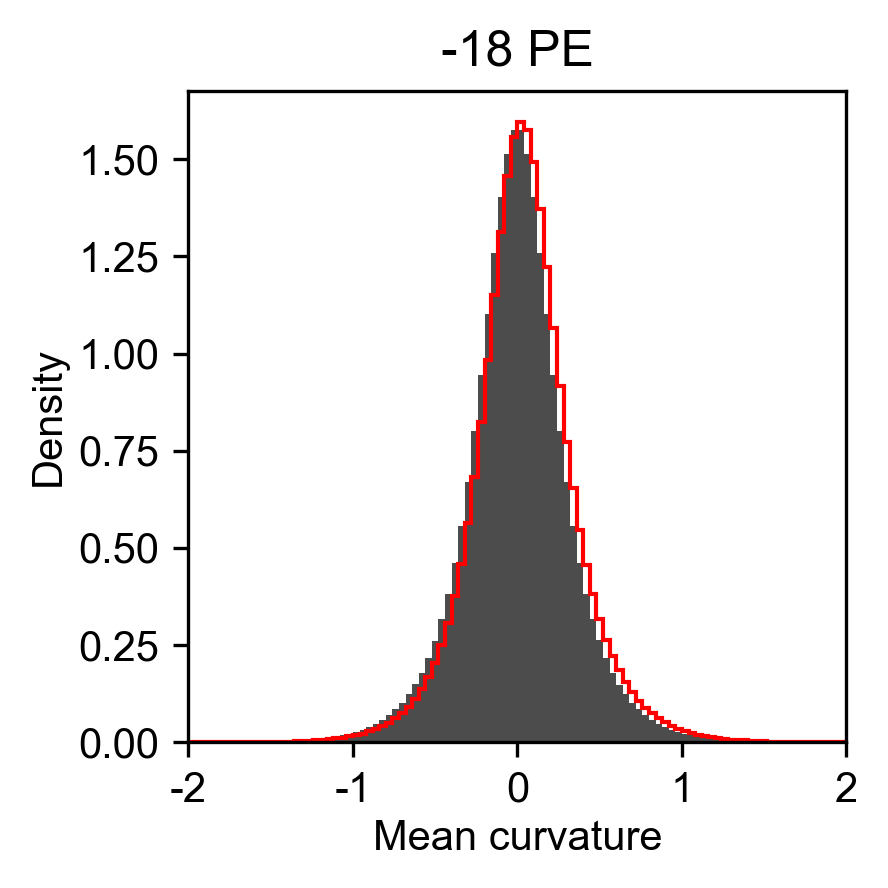

  0%|          | 0/10000 [00:00<?, ?it/s]

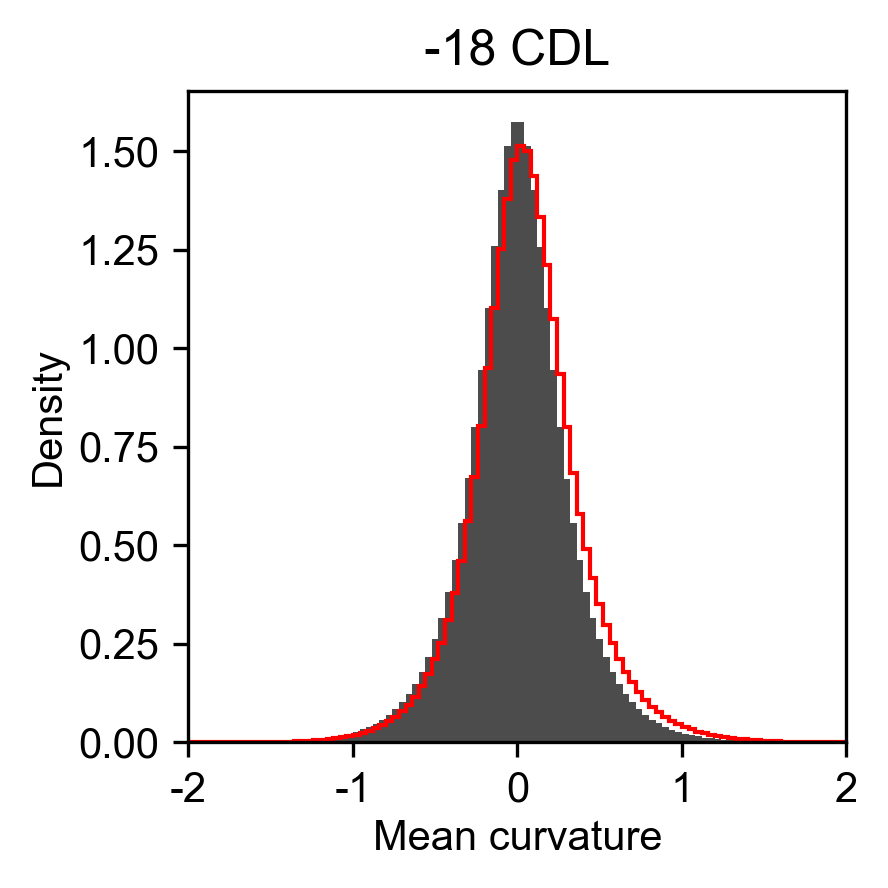

19


  0%|          | 0/10000 [00:00<?, ?it/s]

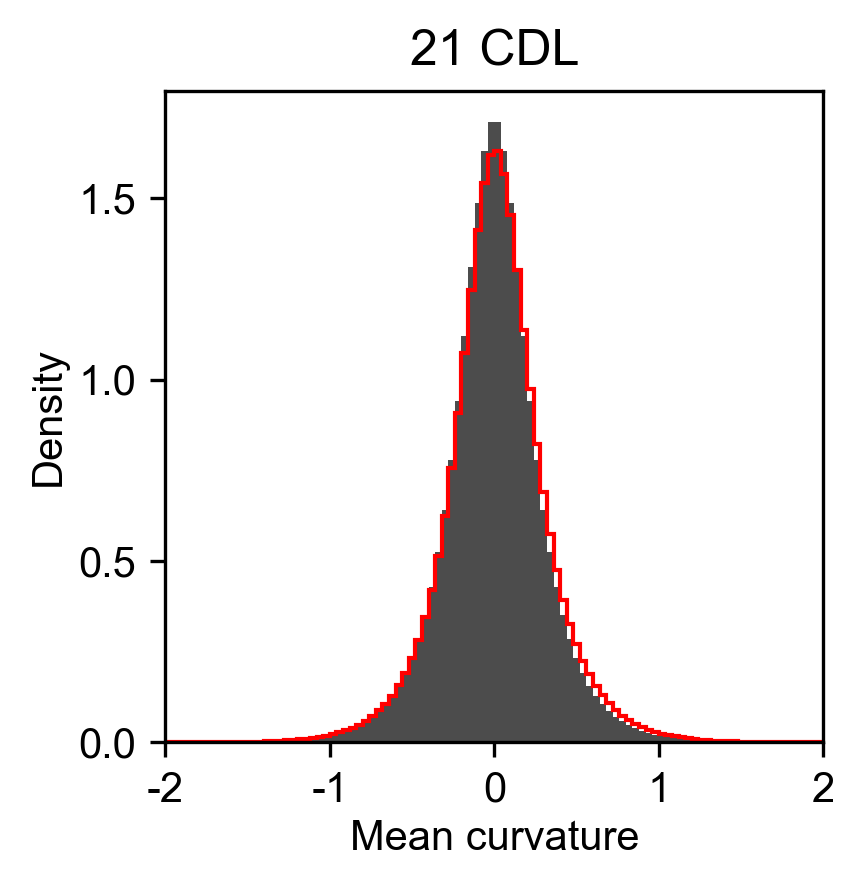

20


  0%|          | 0/10000 [00:00<?, ?it/s]

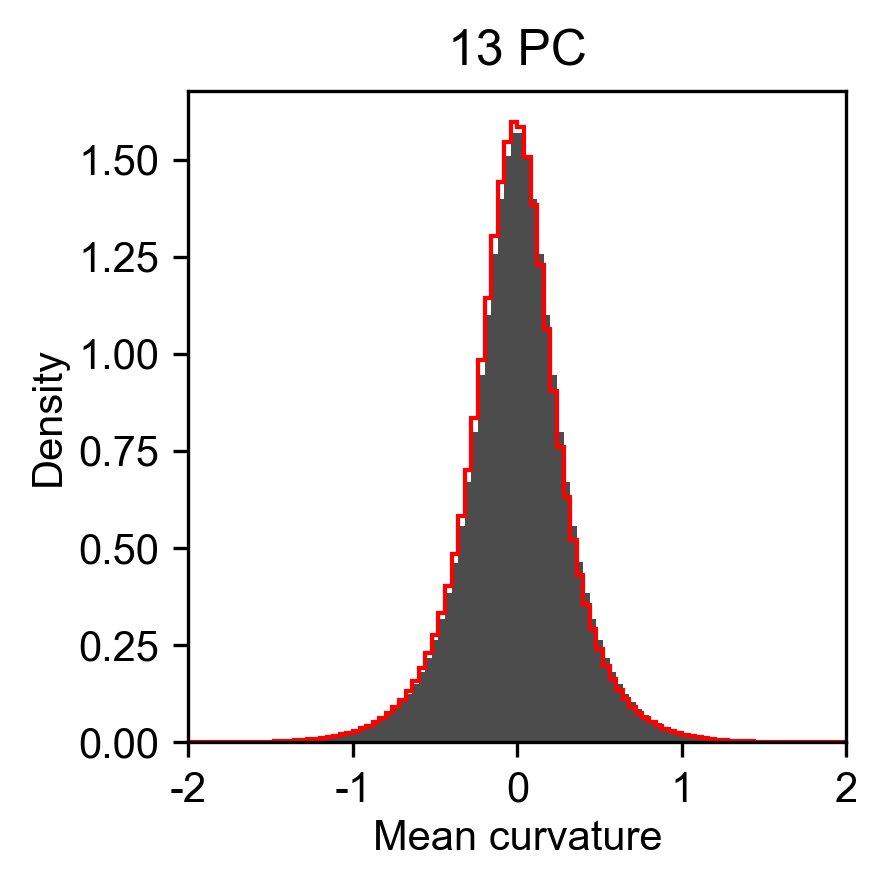

  0%|          | 0/10000 [00:00<?, ?it/s]

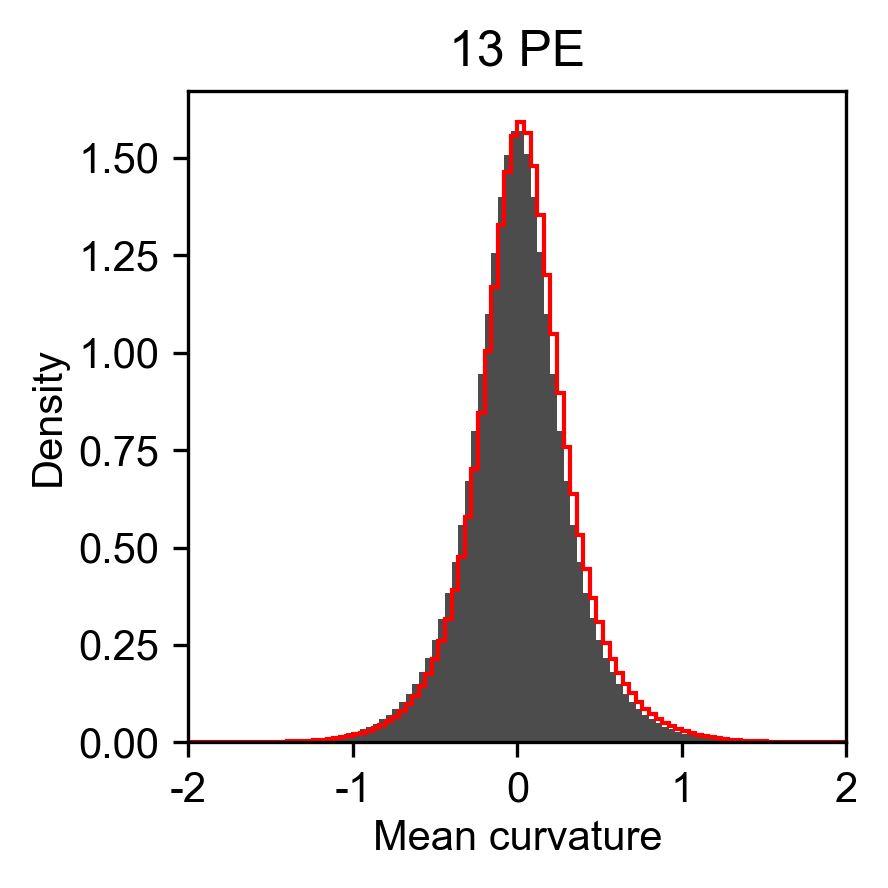

  0%|          | 0/10000 [00:00<?, ?it/s]

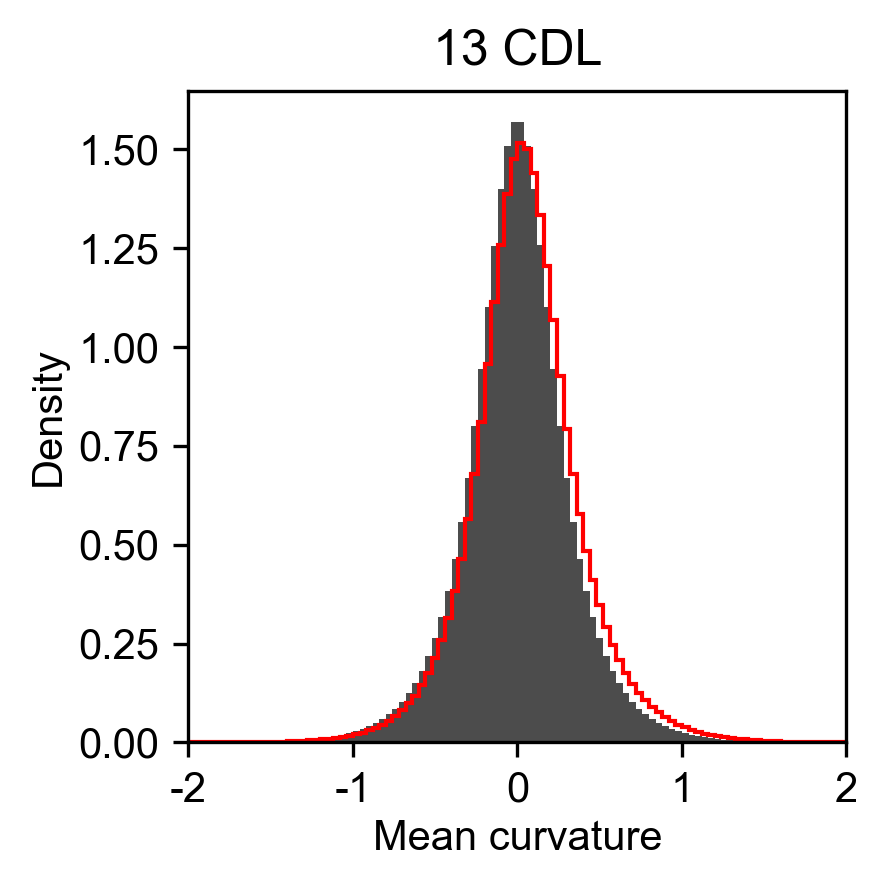

21


  0%|          | 0/10000 [00:00<?, ?it/s]

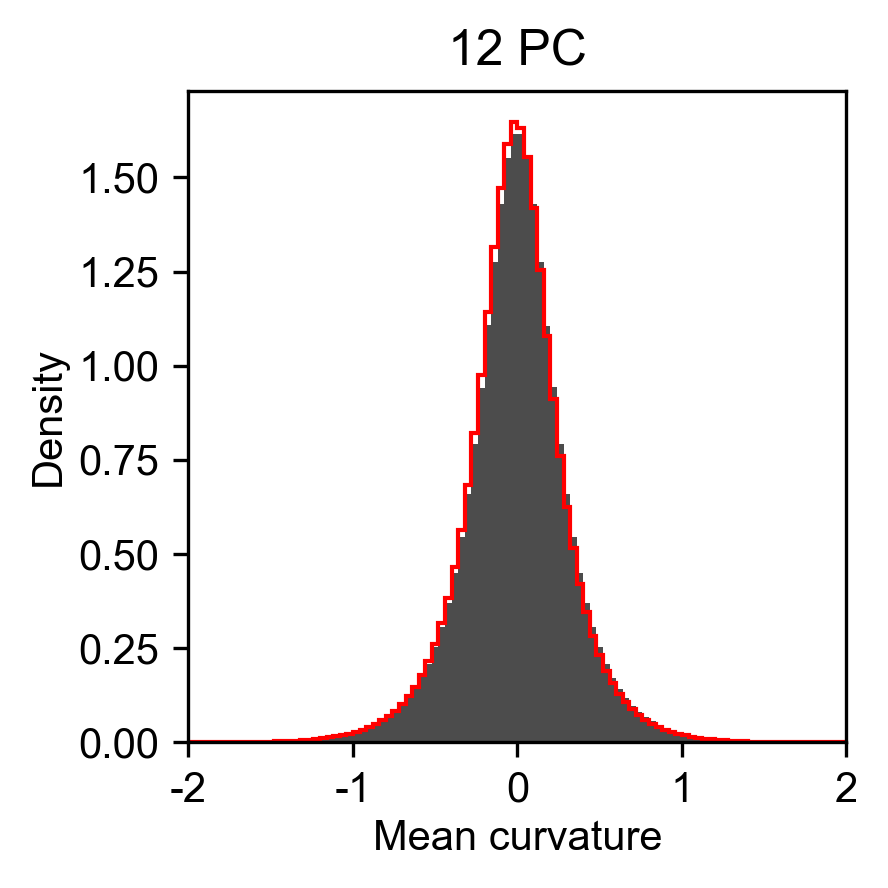

  0%|          | 0/10000 [00:00<?, ?it/s]

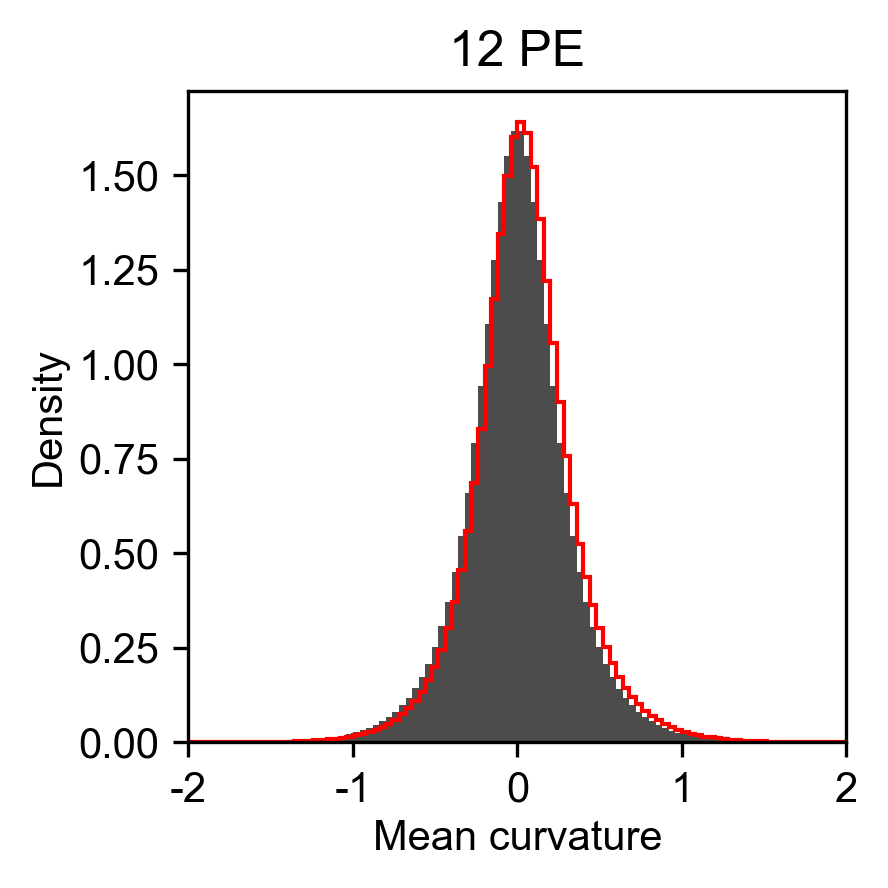

  0%|          | 0/10000 [00:00<?, ?it/s]

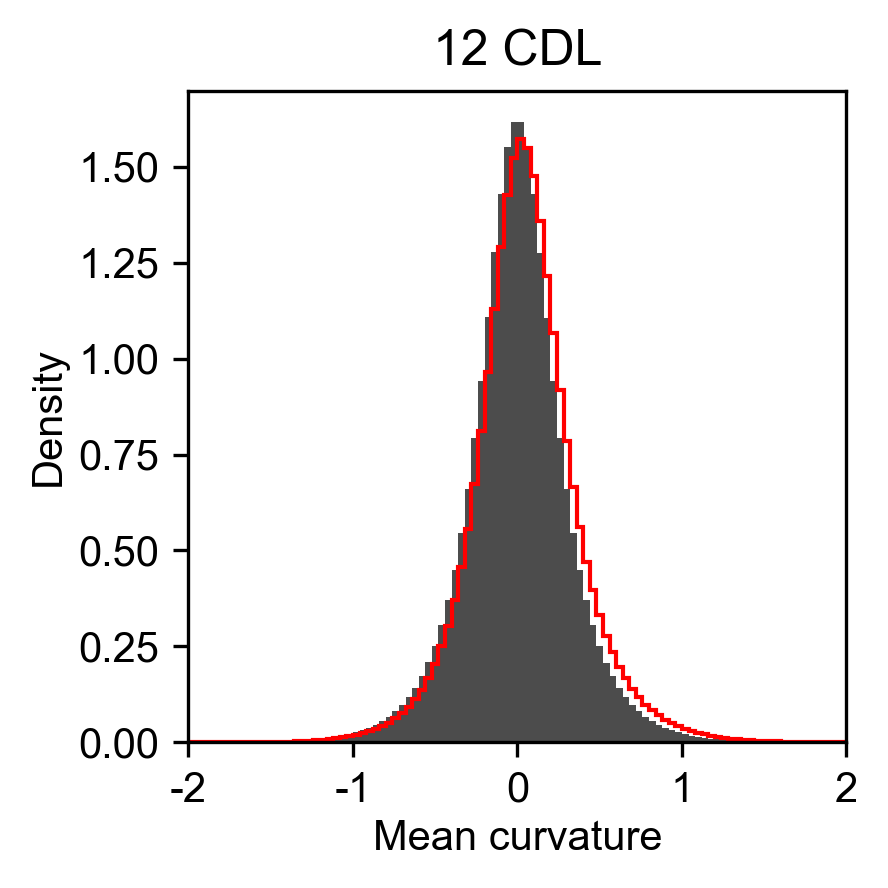

22


  0%|          | 0/10000 [00:00<?, ?it/s]

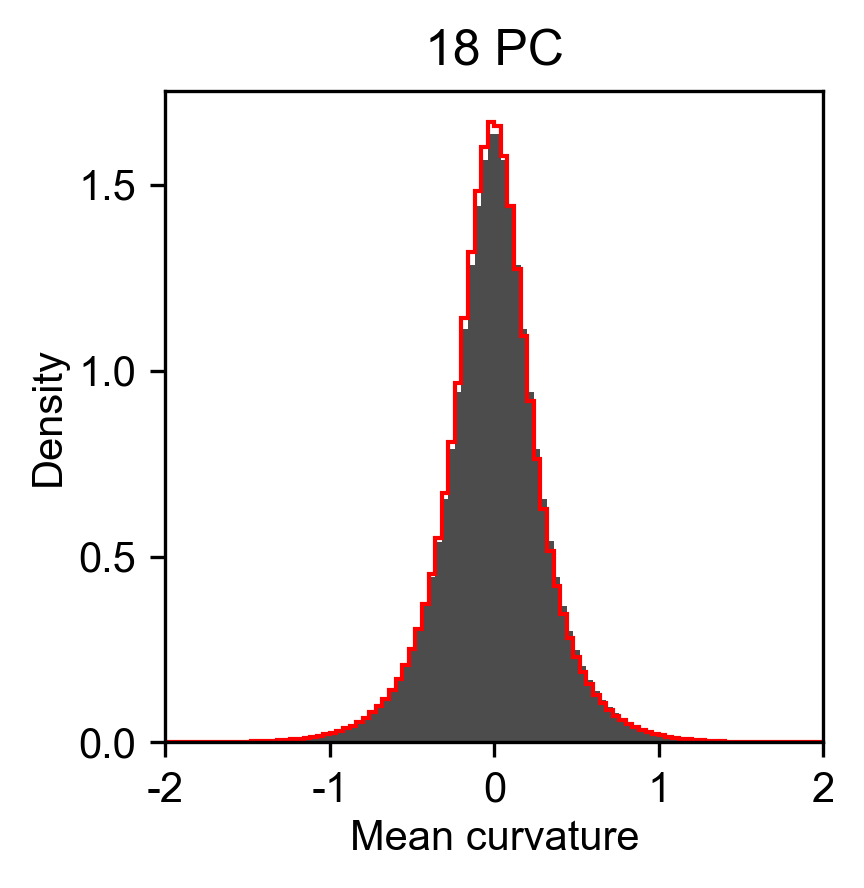

  0%|          | 0/10000 [00:00<?, ?it/s]

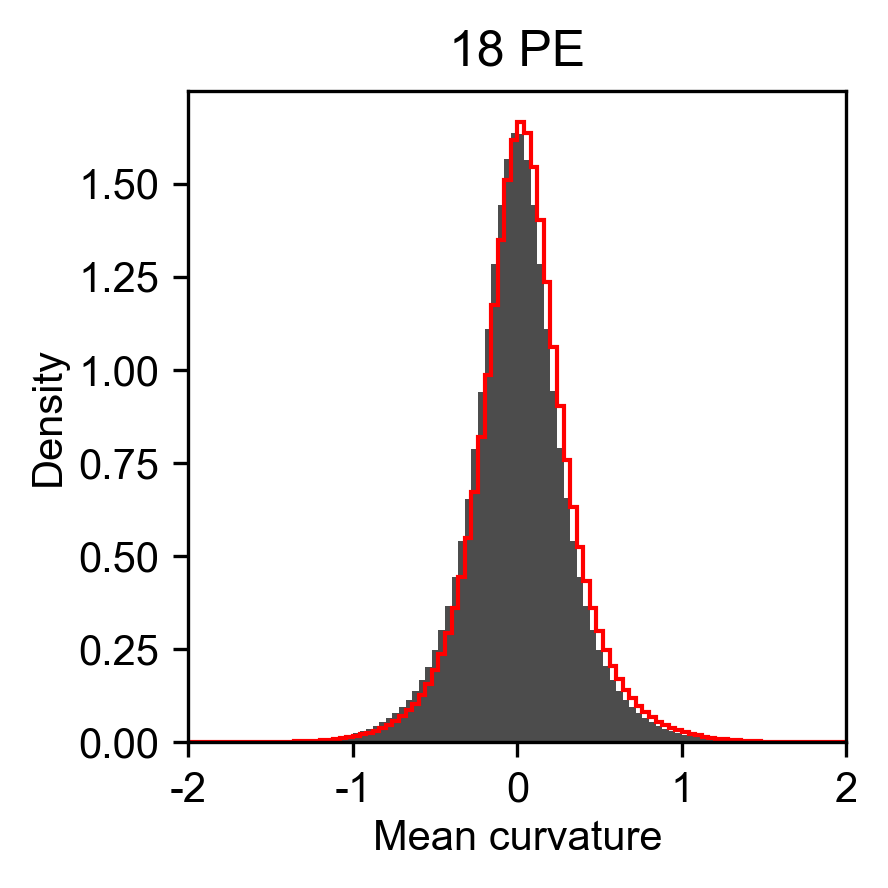

  0%|          | 0/10000 [00:00<?, ?it/s]

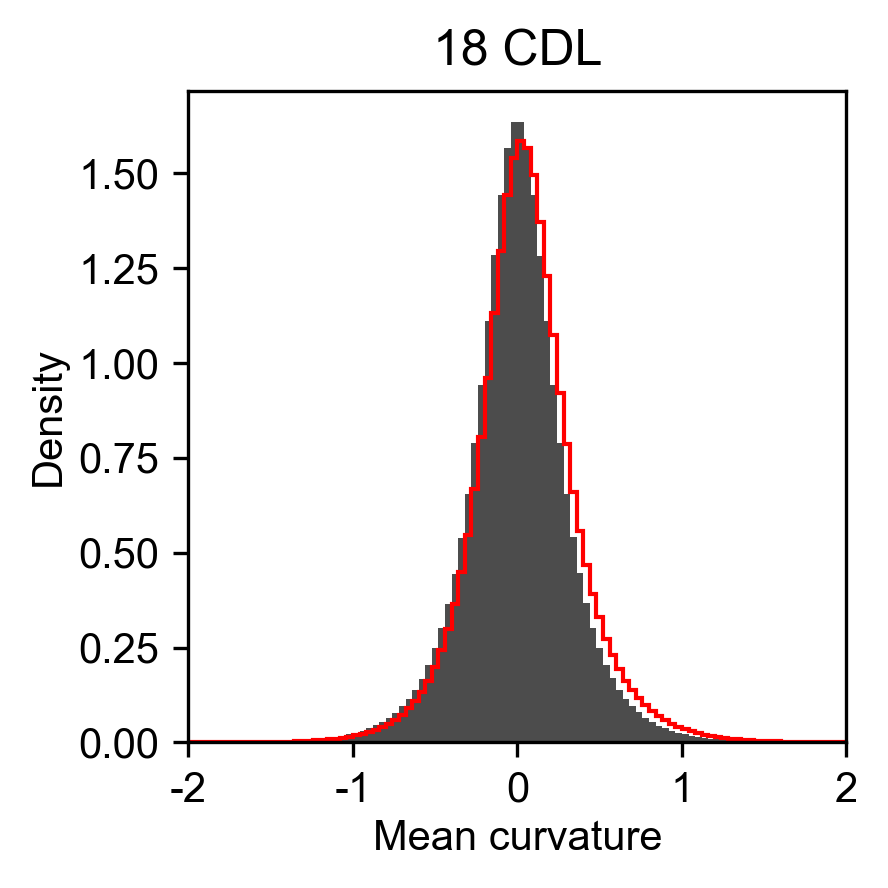

23


  0%|          | 0/10000 [00:00<?, ?it/s]

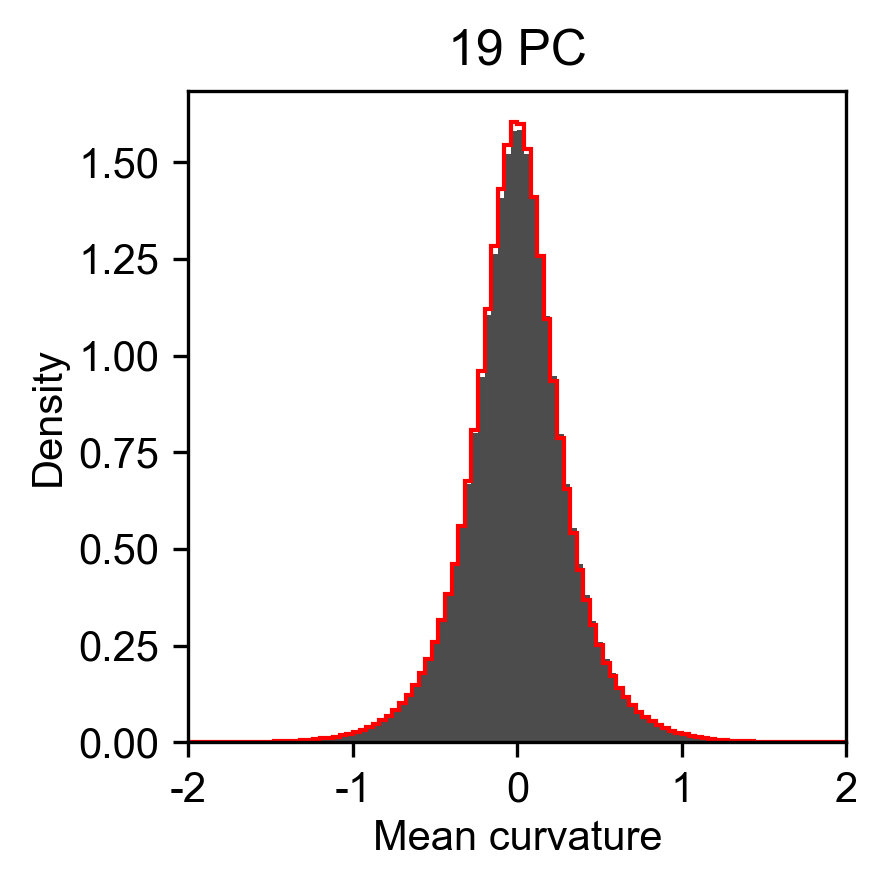

  0%|          | 0/10000 [00:00<?, ?it/s]

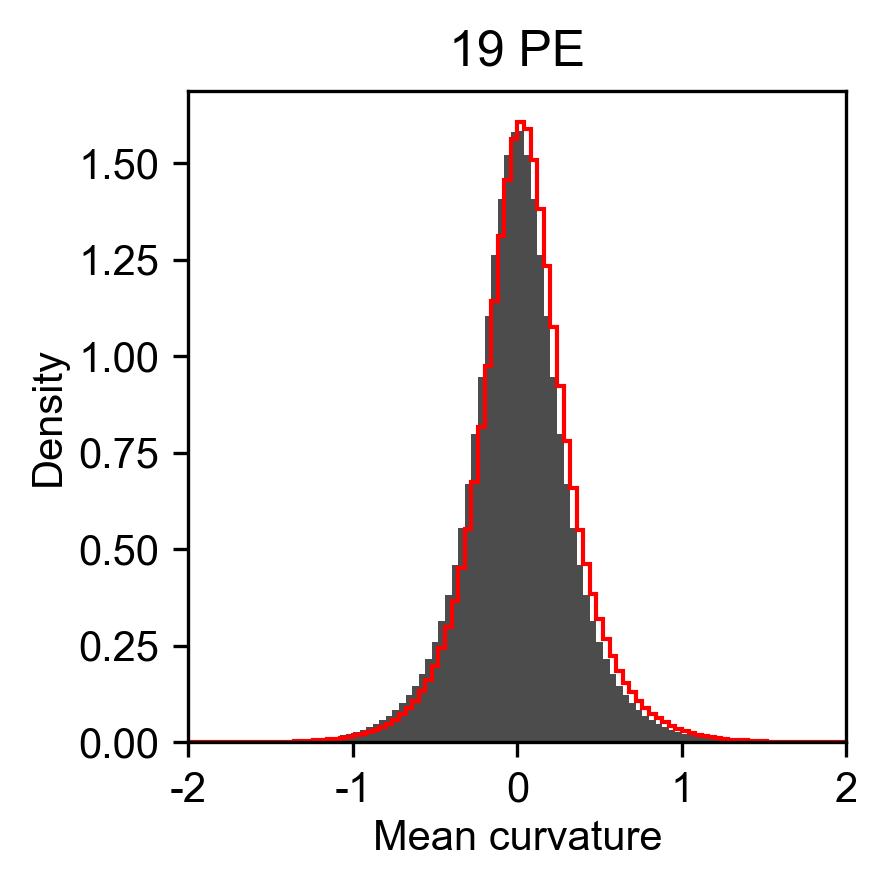

  0%|          | 0/10000 [00:00<?, ?it/s]

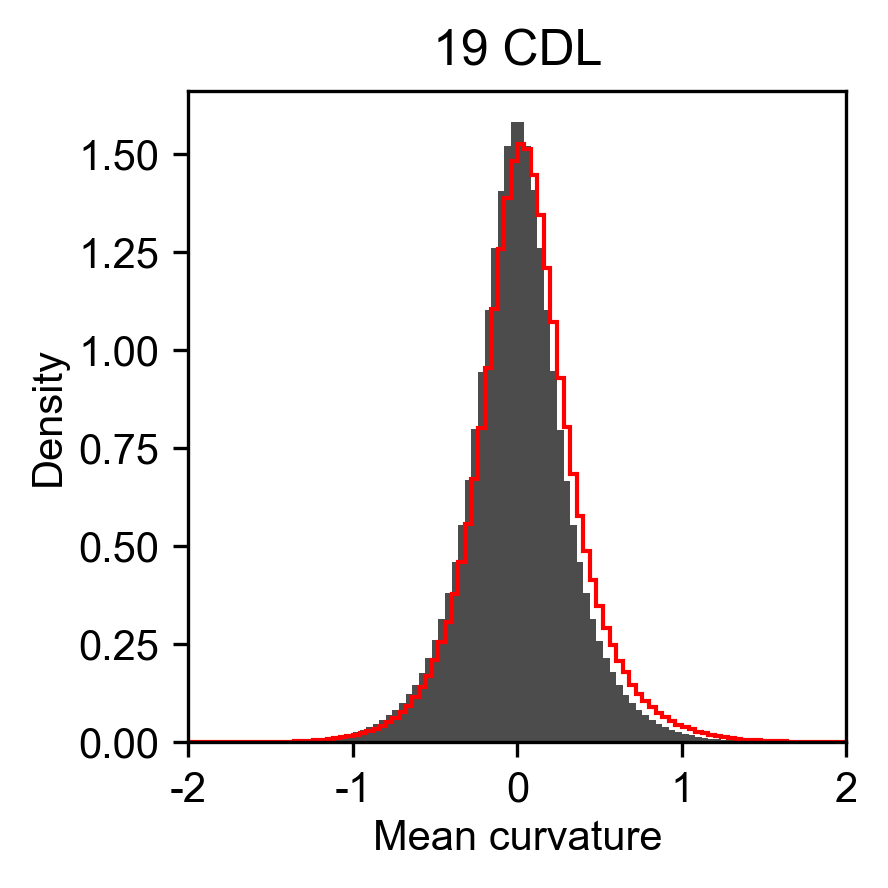

24


  0%|          | 0/10000 [00:00<?, ?it/s]

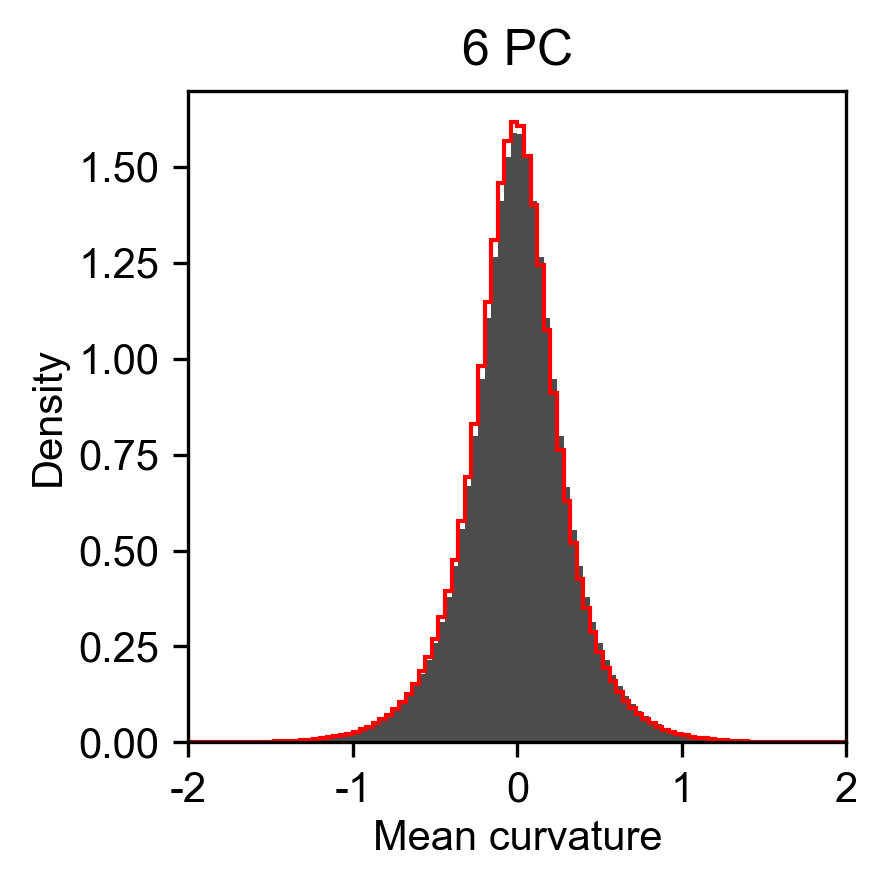

  0%|          | 0/10000 [00:00<?, ?it/s]

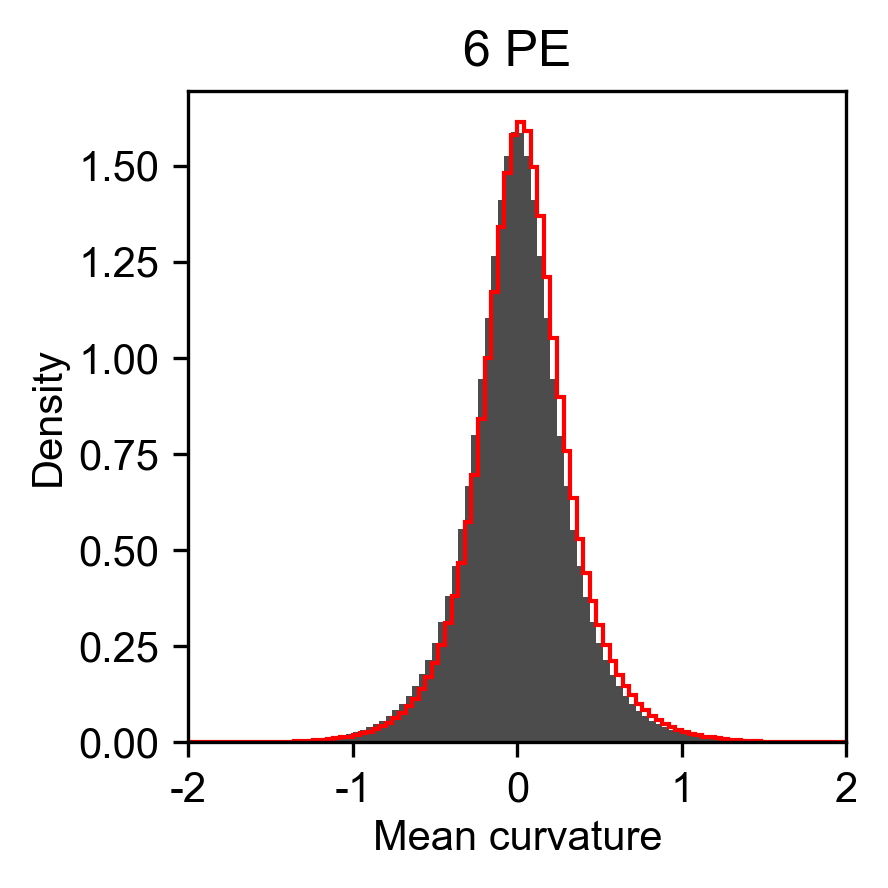

  0%|          | 0/10000 [00:00<?, ?it/s]

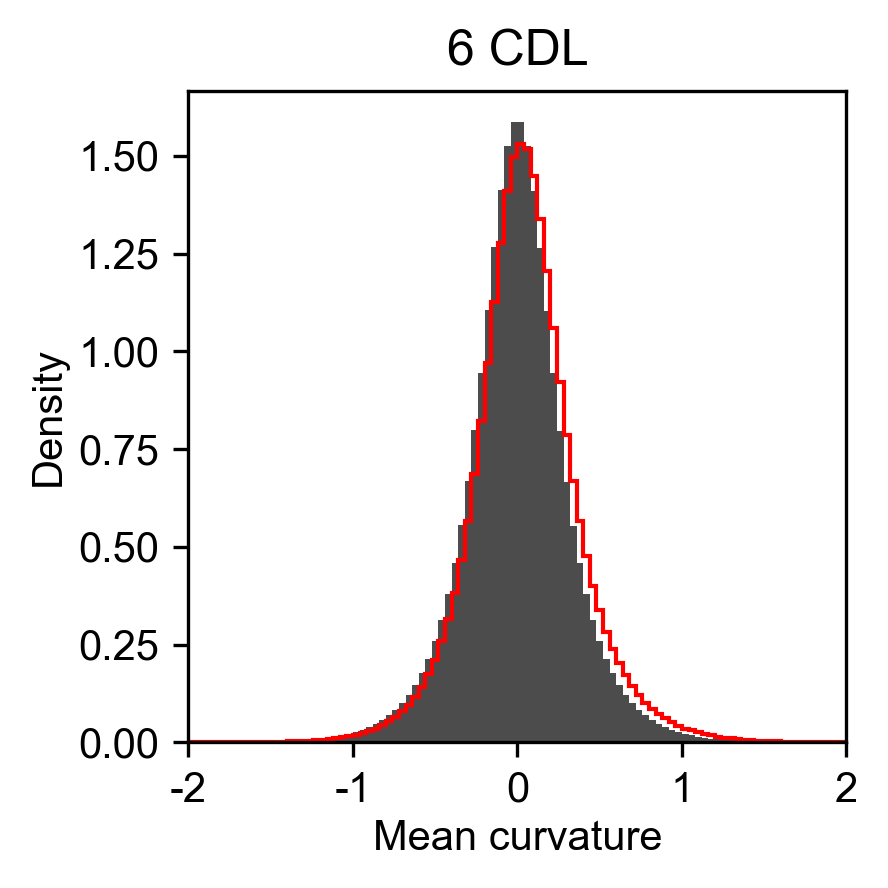

1_vbt


  0%|          | 0/10000 [00:00<?, ?it/s]

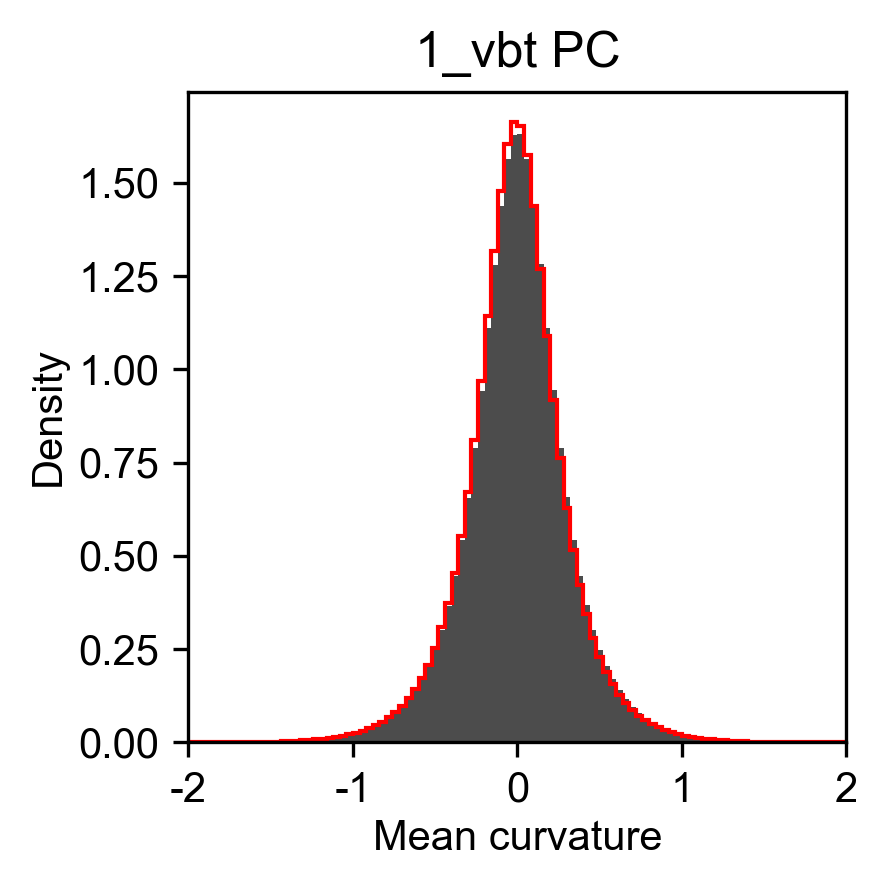

  0%|          | 0/10000 [00:00<?, ?it/s]

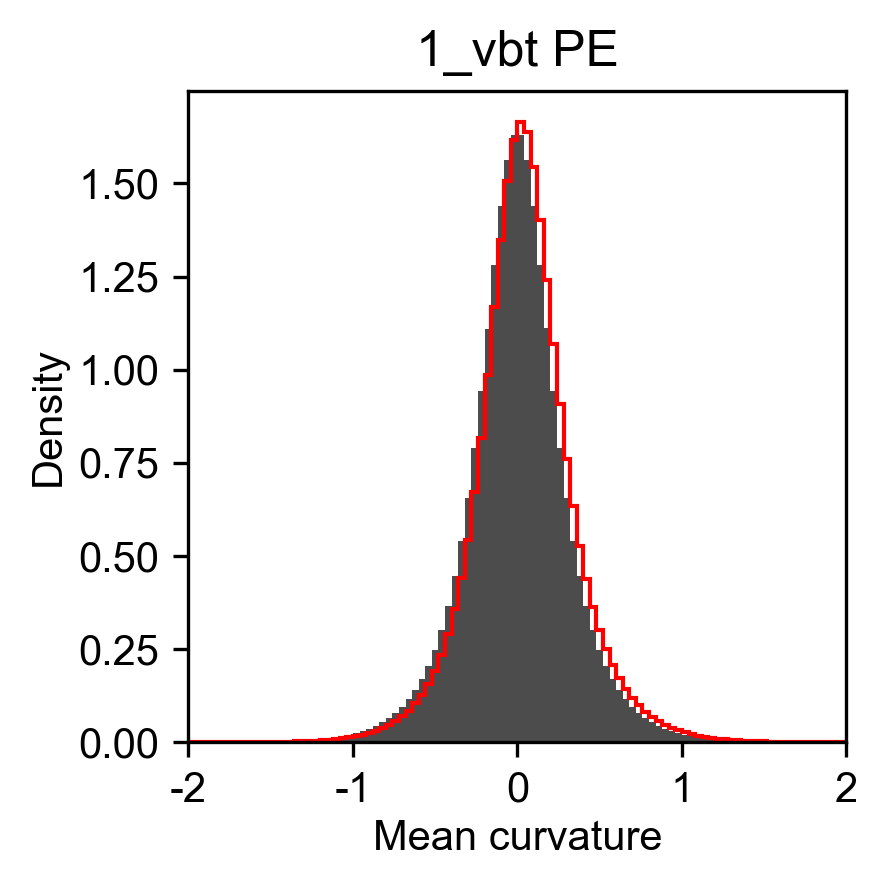

  0%|          | 0/10000 [00:00<?, ?it/s]

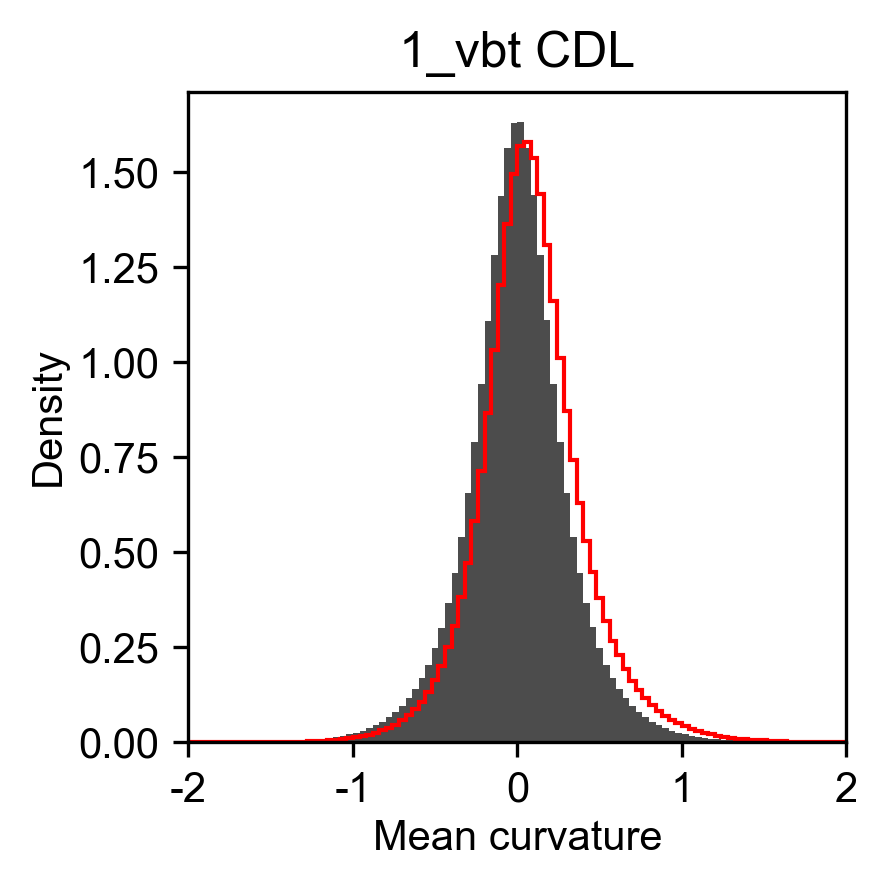

In [5]:
show_figs = True
curr_fig_path = Path("Figures/curvature_histograms")
curr_fig_path.mkdir(parents=True, exist_ok=True)

for sim in np.concatenate((util.simulations, ["1_vbt"])):
    print(sim)
    with open(util.analysis_path / f"{sim}/membrane_curvature.pickle", "rb") as handle:
        mc = pickle.load(handle)

    h = mc.results["height"][1:]
    mean = np.zeros_like(h)
    for i in range(h.shape[0]):
        mean[i] = mean_curvature(h[i])

    gro = util.analysis_path / f"{sim}/po4_only.gro"
    traj = util.analysis_path / f"{sim}/po4_all.xtc"

    u = MDAnalysis.Universe(gro, str(traj), refresh_offsets=True)
    ag = determine_leaflets(u, po4_neighbor_sel)

    for lipid, query in queries.items():
        lipids_upper = ag["upper"].select_atoms(query)
        lipids_lower = ag["lower"].select_atoms(query)

        # print(lipid, len(lipids_upper), len(lipids_lower))
        if len(lipids_upper) == 0:
            continue

        gx = np.arange(mc.x_range[0], mc.x_range[1], mc.x_step)
        gy = np.arange(mc.y_range[0], mc.y_range[1], mc.y_step)
        gxm = get_midpoints(gx)
        gym = get_midpoints(gy)

        hs = []

        for i, ts in tqdm(enumerate(u.trajectory[1:]), total=len(u.trajectory[1:])):
            # u.trajectory[0]
            # Get x, y points of interest
            px = lipids_upper.positions[:, 0]
            py = lipids_upper.positions[:, 1]

            # get indices of closest mesh point
            pxd = np.digitize(px, gxm)
            pyd = np.digitize(py, gym)

            hs.extend(list(mean[i][pxd, pyd]))

            px = lipids_lower.positions[:, 0]
            py = lipids_lower.positions[:, 1]

            # get indices of closest mesh point
            pxd = np.digitize(px, gxm)
            pyd = np.digitize(py, gym)
            hs.extend(list(-mean[i][pxd, pyd]))

        hs = np.array(hs)

        fig, ax = plt.subplots(1, 1, figsize=(3, 3))  # sharex=True,

        ax.hist(hs, bins=100, range=[-2, 2], density=True, histtype="step", color="r")
        ax.hist(
            np.ravel(mean), bins=100, range=[-2, 2], density=True, color="k", alpha=0.7
        )

        ax.set_xlabel(r"Mean curvature")
        ax.set_ylabel(r"Density")

        if sim == "1_vbt":
            ax.set_title(f"1_vbt {lipid}")
        else:
            ax.set_title(f"{util.sim_to_final_index[int(sim)]} {lipid}")
        ax.set_xlim(-2, 2)

        # ax.legend(loc="upper right")

        # # Shrink current axis by 20%
        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # # Put a legend to the right of the current axis
        # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

        fig.tight_layout()

        if sim == "1_vbt":
            fig.savefig(curr_fig_path / f"1_vbt_{lipid}.png", format="png")
            fig.savefig(curr_fig_path / f"1_vbt_{lipid}.pdf", format="pdf")
        else:
            fig.savefig(
                curr_fig_path / f"{util.sim_to_final_index[int(sim)]}_{lipid}.png",
                format="png",
            )
            fig.savefig(
                curr_fig_path / f"{util.sim_to_final_index[int(sim)]}_{lipid}.pdf",
                format="pdf",
            )

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)